In [65]:
#'''
import numpy as np
import pandas as pd
import pyjags
import pystan
import stan_utility_copy
import pickle
import matplotlib.pyplot as plt
#'''
from pystan import StanModel
from __future__ import division, print_function
from pandas.tools.plotting import *
from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["font.size"] = 20
#plt.style.use('ggplot')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
#%qtconsole





In [66]:
## function to draw from truncated normal, this function will be used for both the 
## one- and two-componenet cases in this workbook.  

def rnorm_bound( Ndata, mu, prec, lower_bound = 0.0, upper_bound = float('Inf')):
    x = np.zeros(Ndata)
    #print(x)
    for i in range(0, Ndata): 
            #print(i)
            while True:
                x[i] = np.random.normal(mu,prec,1)
                if( (x[i]>lower_bound) and (x[i]<upper_bound) ): 
                    break
    return x;

In [67]:
## Below we designate the population values of our two-component truncated Gaussian 
## generative model. These are the truths that we should recover if our hiararchical 
## Bayesian model is properly specified and diagnostics have indicated that the simulation 
## has "not not converged".
Ndata = 25
Nm = 2
frac = [0.7,0.3]
sigmae = [0.05,0.3]

## After generating values from the population model, we now add realistic Gaussian noise 
## to create simulated measurements. 
sigmahobs = 0.04
sigmakobs = 0.08

h = np.repeat(0.,Ndata)
k = np.repeat(0.,Ndata)
hhat = np.repeat(0.,Ndata)
khat = np.repeat(0.,Ndata)
hhat_sigma  = np.repeat(sigmahobs,Ndata)
khat_sigma  = np.repeat(sigmakobs,Ndata)

#print(khat_sigma)

for i in range(0,Ndata):
    #print('i')
    #print(i)
    
    c = np.random.choice(len(frac), 1, p=frac, replace=True)
    #print(int(c))
    h[i] = rnorm_bound(1,0,sigmae[int(c)],lower_bound=-1,upper_bound=1)
    # Euler's formula: h^2 + k^2 = 1
    lb = -np.sqrt(1-h[i]**2)
    ub = np.sqrt(1-h[i]**2)
    k[i] = rnorm_bound(1,0,sigmae[int(c)],lower_bound=lb,upper_bound=ub) 
    hhat[i] = rnorm_bound(1,h[i],sigmahobs,lower_bound=-1,upper_bound=1)
    khat[i] = rnorm_bound(1,k[i],sigmakobs,lower_bound=lb,upper_bound=ub)

    
print(h, hhat, k, khat)
print(k.shape)

[-0.15137479 -0.02419367 -0.00618365  0.03459234  0.00702352 -0.00346412
 -0.02925159  0.0165107  -0.03430117  0.06908211  0.00543866 -0.02451476
  0.02002942 -0.02632851 -0.02827235  0.09020623  0.01358015  0.04603621
 -0.11247641  0.69685127  0.07211412 -0.05806656 -0.08424351 -0.04641255
  0.02220126] [-0.15032612 -0.05163447  0.01482432  0.08009508 -0.01071882  0.07226861
 -0.01169972  0.01007465  0.02065977  0.08350954 -0.02372982  0.04716752
  0.03154969 -0.00438168 -0.0507728   0.09671597  0.00990936  0.01740743
 -0.0990802   0.82271992  0.03175029 -0.05852685 -0.02062162 -0.00444821
  0.03801583] [ 0.15637435 -0.0318769   0.06458541  0.10319063  0.07002341  0.00366181
  0.01614046  0.01856833 -0.02606708  0.04878581 -0.00206864 -0.01325234
  0.01281673 -0.02992281  0.01787055  0.04947821  0.00159438  0.04755138
  0.00565889 -0.07479398  0.00502104 -0.02532041 -0.00391264 -0.40087964
 -0.06086617] [ 0.19271899 -0.01245914  0.01218373  0.16528109 -0.03065601 -0.06571444
 -0.02827

(array([  3.,  16.,   5.,   0.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([-0.15032612, -0.05302152,  0.04428308,  0.14158769,  0.23889229,
         0.3361969 ,  0.4335015 ,  0.53080611,  0.62811071,  0.72541531,
         0.82271992]),
 <a list of 10 Patch objects>)

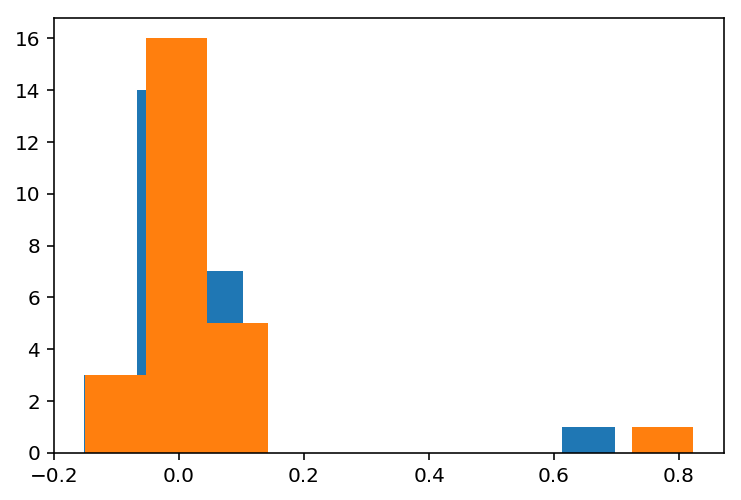

In [68]:
plt.hist(h)
plt.hist(hhat)

(array([  1.,   0.,   0.,   0.,   2.,   2.,  11.,   4.,   2.,   3.]),
 array([-0.45695173, -0.38982251, -0.32269329, -0.25556406, -0.18843484,
        -0.12130562, -0.05417639,  0.01295283,  0.08008205,  0.14721128,
         0.2143405 ]),
 <a list of 10 Patch objects>)

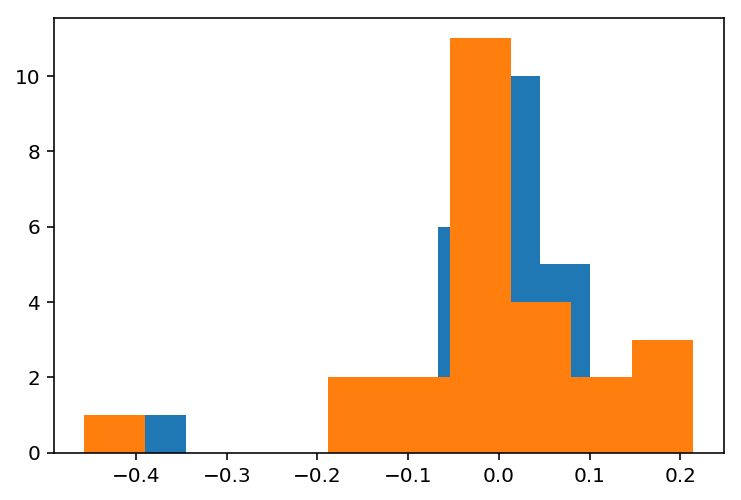

In [69]:
plt.hist(k)
plt.hist(khat)

In [70]:
'''
## One-component Gaussian Mixture Simulated Data
## Below we designate the population values of our generative model. These are the 
## truths that we should recover if our hiararchical Bayesian model is properly specified 
## and diagnostics have indicated that the simulation has "not not converged". "You can't 
## prove convergence, at best you can fail to prove a failure to converge".

## In this simulated data set, their are 50 planetary systems (with one planet each)
Ndata = 25 
## Here we asign the dispersion of the simulated population to be 0.3, this is 
## the truth we wish to recovern 
sigmae = 0.3 
## We approximate the uncertainty for each measurement as normally distributed about a 
## reporte measurement point estimate.  For the eccentricity distribution for Hot Jupiter
## the physical models used to derive these produce larger uncertainty in k by a factor of 2. 
sigmahobs = 0.04
sigmakobs = 0.08

h = np.repeat(0.,Ndata)
k = np.repeat(0.,Ndata)
hhat = np.repeat(0.,Ndata)
khat = np.repeat(0.,Ndata)
hhat_sigma  = np.repeat(sigmahobs,Ndata)
khat_sigma  = np.repeat(sigmakobs,Ndata)

#print(khat_sigma)


for i in range(0,Ndata):
    h[i] = rnorm_bound(1,0,sigmae,lower_bound=-1,upper_bound=1)
    lb = -np.sqrt(1-h[i]**2)
    ub = np.sqrt(1-h[i]**2)
    k[i] = rnorm_bound(1,0,sigmae,lower_bound=lb,upper_bound=ub) 
    hhat[i] = rnorm_bound(1,h[i],sigmahobs,lower_bound=-1,upper_bound=1)
    khat[i] = rnorm_bound(1,k[i],sigmakobs,lower_bound=lb,upper_bound=ub)

## Vizualize the true data values, and the simulated measurements:     
print(h, hhat, k, khat)
plt.hist(h)
plt.hist(hhat)
'''

'\n## One-component Gaussian Mixture Simulated Data\n## Below we designate the population values of our generative model. These are the \n## truths that we should recover if our hiararchical Bayesian model is properly specified \n## and diagnostics have indicated that the simulation has "not not converged". "You can\'t \n## prove convergence, at best you can fail to prove a failure to converge".\n\n## In this simulated data set, their are 50 planetary systems (with one planet each)\nNdata = 25 \n## Here we asign the dispersion of the simulated population to be 0.3, this is \n## the truth we wish to recovern \nsigmae = 0.3 \n## We approximate the uncertainty for each measurement as normally distributed about a \n## reporte measurement point estimate.  For the eccentricity distribution for Hot Jupiter\n## the physical models used to derive these produce larger uncertainty in k by a factor of 2. \nsigmahobs = 0.04\nsigmakobs = 0.08\n\nh = np.repeat(0.,Ndata)\nk = np.repeat(0.,Ndata)\nhhat

In [9]:
%%time
!date

eccmodel = """
data {
    int<lower=1> Nm;
    int<lower=1> Ndata;
    real<lower=-1,upper=1> hhat[Ndata];
    real<lower=0,upper=1> hhat_sigma[Ndata];
    real<lower=-1,upper=1> khat[Ndata];
    real<lower=0,upper=1> khat_sigma[Ndata];

}
parameters {
    //real<lower=0,upper=1> f;
    simplex[Nm] f;
    real<lower=0> e_sigma[Nm];
    real<lower=-1,upper=1> h[Ndata];
    real<lower=-1,upper=1> k[Ndata];
}
model {
    e_sigma ~ uniform(0, 1.0);
    
    for (n in 1:Ndata)
      hhat[n] ~ normal(h[n], hhat_sigma[n]);
    for (n in 1:Ndata)
      khat[n] ~ normal(k[n], khat_sigma[n]);

    for (n in 1:Ndata)
      increment_log_prob(log_mix(f[1], normal_log(h[n], 0.0, e_sigma[1]), normal_log(h[n], 0.0, e_sigma[2])));
    for (n in 1:Ndata)
      increment_log_prob(log_mix(f[1], normal_log(k[n], 0.0, e_sigma[1]), normal_log(k[n], 0.0, e_sigma[2])));
}
"""
# Compiled Stan Model
sm = StanModel(model_code=eccmodel)

!date

In [10]:
%%time
!date
ecc_dat = {'Nm': 2, 'Ndata': len(hhat), 'alpha': [1], 'hhat': hhat, 'hhat_sigma': hhat_sigma, 'khat': khat, 'khat_sigma': khat_sigma}


fit = sm.sampling(data=ecc_dat, iter=50000, chains=5, seed=483892929, refresh=1000, n_jobs=-1)

!date

Tue Dec 19 15:32:06 PST 2017
Tue Dec 19 15:48:57 PST 2017
CPU times: user 983 ms, sys: 454 ms, total: 1.44 s
Wall time: 16min 50s


In [20]:
la = fit.extract(permuted=True)  # return a dictionary of arrays

a = fit.extract(permuted=False)

#print(la)



In [13]:
## I found Python stan_utility on Jeff Alstott's github: https://github.com/jeffalstott/pystan_time_series
## I am refereing to the Stan Case Studies for HMC diagnostics in pystan:
## http://mc-stan.org/users/documentation/case-studies/pystan_workflow.html

help(stan_utility_copy)

Help on module stan_utility_copy:

NAME
    stan_utility_copy

FILE
    /Users/meganshabram/Dropbox/Graduate_School/ecc_dist_Stan_example/stan_utility_copy.py

DESCRIPTION
    #Copyright 2017 Columbia University, 2017 Jeff Alstott
    #
    #Redistribution and use in source and binary forms, with or without modification, are permitted provided that the following conditions are met:
    #
    #1. Redistributions of source code must retain the above copyright notice, this list of conditions and the following disclaimer.
    #
    #2. Redistributions in binary form must reproduce the above copyright notice, this list of conditions and the following disclaimer in the documentation and/or other materials provided with the distribution.
    #
    #3. Neither the name of the copyright holder nor the name INCLUDING, BUT NOT LIMITED TO, THE IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT HOLDER OR CONTRIBUTORS BE LIABLE 

Inference for Stan model: anon_model_8f576dc713862e4b91e0f0a8f3f767ab.
5 chains, each with iter=50000; warmup=25000; thin=1; 
post-warmup draws per chain=25000, total post-warmup draws=125000.

             mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
f[0]         0.33    0.14   0.24   0.08   0.16   0.23   0.36   0.88    3.0   2.88
f[1]         0.67    0.14   0.24   0.12   0.64   0.77   0.84   0.92    3.0   2.88
e_sigma[0]   0.36     0.1    0.2   0.04   0.27   0.37   0.47   0.78    4.0   1.59
e_sigma[1]   0.14    0.09   0.16   0.04   0.05   0.06   0.09    0.6    3.0   2.61
h[0]         0.09  1.1e-4   0.04   0.02   0.06   0.09   0.12   0.17 125000    1.0
h[1]        -0.03  9.6e-5   0.03   -0.1  -0.05  -0.03-8.1e-3   0.03 125000    1.0
h[2]        -0.07  1.0e-4   0.04  -0.14  -0.09  -0.07  -0.04-1.1e-3 125000    1.0
h[3]        -0.06  1.0e-4   0.04  -0.13  -0.08  -0.06  -0.03 8.6e-3 125000    1.0
h[4]        -0.07  1.0e-4   0.04  -0.14  -0.09  -0.06  -0.04 2.3e-3 

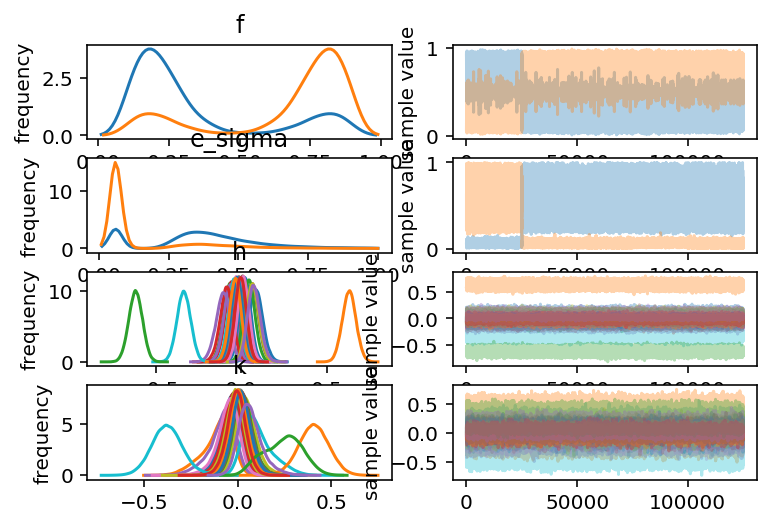

In [23]:
print(fit)
stan_utility_copy.check_treedepth(fit)
stan_utility_copy.check_energy(fit)
stan_utility_copy.check_div(fit)
fig = fit.traceplot()

(119231,)
(5769,)
(119231,)
(5769,)


Text(0,0.5,u'e_sigma')

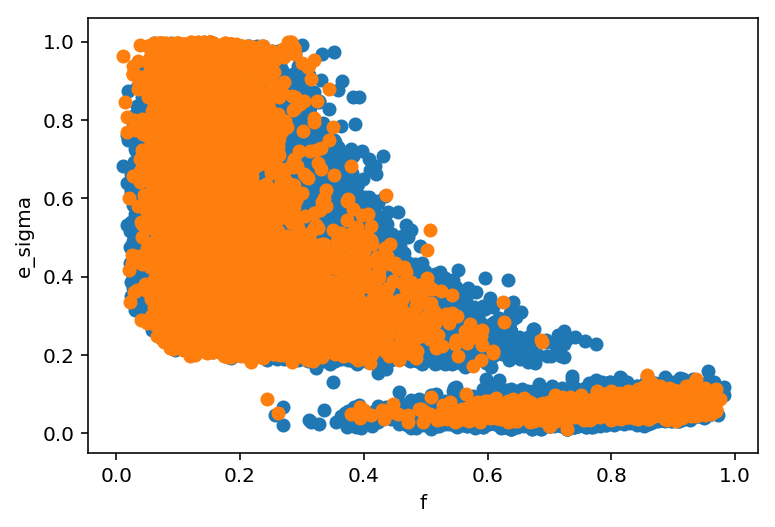

In [15]:
light="#DCBCBC"
light_highlight="#C79999"
mid="#B97C7C"
mid_highlight="#A25050"
dark="#8F2727"
dark_highlight="#7C0000"
green="#00FF00"

nondiv_params, div_params = stan_utility_copy.partition_div(fit)
print(nondiv_params['e_sigma'][:,0].shape)
print(div_params['e_sigma'][:,0].shape)
print(nondiv_params['f'][:,0].shape)
print(div_params['f'][:,0].shape)
#plt.scatter([x[0] for x in nondiv_params['f'][:,0]], nondiv_params['e_sigma'][:,0], \
             #color = mid_highlight, alpha=0.05)
#plt.scatter([x[0] for x in div_params['f'][:,0]], div_params['e_sigma'][:,0], \
             #color = green, alpha=0.5)

plt.scatter(nondiv_params['f'][:,0], nondiv_params['e_sigma'][:,0])
plt.scatter(div_params['f'][:,0], div_params['e_sigma'][:,0])

plt.gca().set_xlabel("f")
plt.gca().set_ylabel("e_sigma")



In [16]:
%%time
fit2 = sm.sampling(data=ecc_dat, iter=10000, chains=5, seed=483892929, refresh=1000, n_jobs=-1, control=dict(adapt_delta=0.99))


CPU times: user 740 ms, sys: 227 ms, total: 967 ms
Wall time: 14min 20s


Inference for Stan model: anon_model_8f576dc713862e4b91e0f0a8f3f767ab.
5 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=25000.

             mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
f[0]         0.33    0.14   0.24   0.08   0.16   0.23   0.37   0.88    3.0   2.87
f[1]         0.67    0.14   0.24   0.12   0.63   0.77   0.84   0.92    3.0   2.87
e_sigma[0]   0.36     0.1    0.2   0.04   0.27   0.37   0.47   0.79    4.0   1.59
e_sigma[1]   0.14    0.09   0.16   0.04   0.05   0.07   0.09    0.6    3.0   2.64
h[0]         0.09  2.5e-4   0.04   0.02   0.06   0.09   0.12   0.17  25000    1.0
h[1]        -0.03  2.2e-4   0.03   -0.1  -0.05  -0.03-8.2e-3   0.03  25000    1.0
h[2]        -0.07  2.3e-4   0.04  -0.14  -0.09  -0.07  -0.04-4.7e-4  25000    1.0
h[3]        -0.06  2.3e-4   0.04  -0.13  -0.08  -0.06  -0.03 8.2e-3  25000    1.0
h[4]        -0.07  2.3e-4   0.04  -0.14  -0.09  -0.06  -0.04 3.2e-3  25

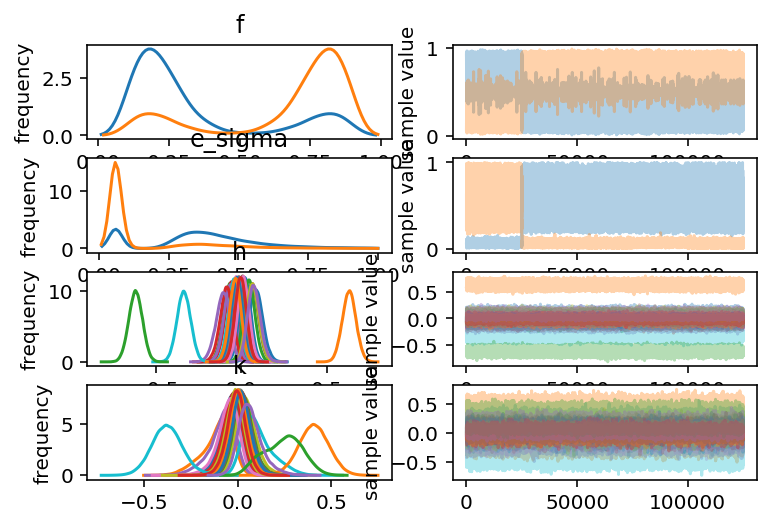

In [21]:
print(fit2)
stan_utility_copy.check_treedepth(fit2)
stan_utility_copy.check_energy(fit2)
stan_utility_copy.check_div(fit2)
fig = fit.traceplot()

(24000,)
(1000,)
(24000,)
(1000,)


Text(0,0.5,u'e_sigma')

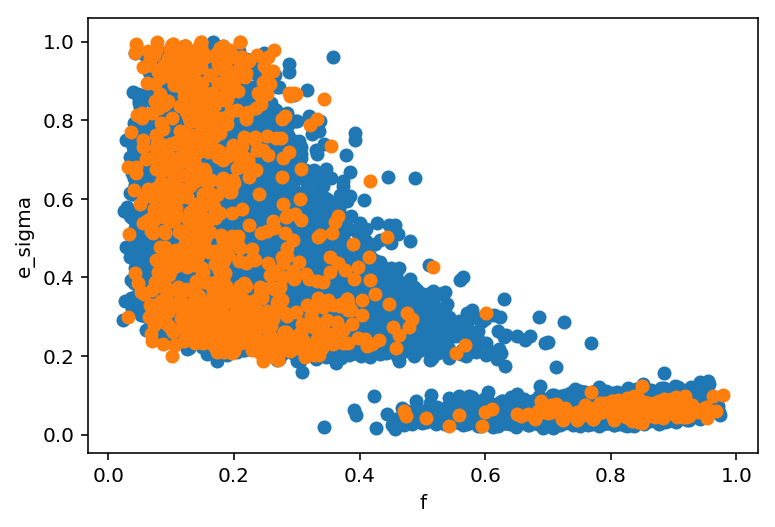

In [24]:
light="#DCBCBC"
light_highlight="#C79999"
mid="#B97C7C"
mid_highlight="#A25050"
dark="#8F2727"
dark_highlight="#7C0000"
green="#00FF00"

nondiv_params, div_params = stan_utility_copy.partition_div(fit2)
print(nondiv_params['e_sigma'][:,0].shape)
print(div_params['e_sigma'][:,0].shape)
print(nondiv_params['f'][:,0].shape)
print(div_params['f'][:,0].shape)
#plt.scatter([x[0] for x in nondiv_params['f'][:,0]], nondiv_params['e_sigma'][:,0], \
             #color = mid_highlight, alpha=0.05)
#plt.scatter([x[0] for x in div_params['f'][:,0]], div_params['e_sigma'][:,0], \
             #color = green, alpha=0.5)

plt.scatter(nondiv_params['f'][:,0], nondiv_params['e_sigma'][:,0])
plt.scatter(div_params['f'][:,0], div_params['e_sigma'][:,0])

plt.gca().set_xlabel("f")
plt.gca().set_ylabel("e_sigma")


In [25]:
num_chains = 5
samples_Stan = fit2.extract(permuted=True)
print(type(samples_Stan['e_sigma'][:,0]))
print(samples_Stan.items())

for j, i in samples_Stan.items():
    print(j)
    print(i.shape)
    



<type 'numpy.ndarray'>
[(u'f', array([[ 0.87853327,  0.12146673],
       [ 0.79134321,  0.20865679],
       [ 0.90513068,  0.09486932],
       ..., 
       [ 0.22416918,  0.77583082],
       [ 0.2966192 ,  0.7033808 ],
       [ 0.16054815,  0.83945185]])), (u'e_sigma', array([[ 0.05060286,  0.74246119],
       [ 0.0771424 ,  0.51616174],
       [ 0.07119436,  0.34046479],
       ..., 
       [ 0.41658485,  0.06446178],
       [ 0.38053465,  0.05191015],
       [ 0.39028953,  0.0762385 ]])), (u'h', array([[ 0.05373502, -0.06637197, -0.05735888, ..., -0.61323444,
        -0.00813336,  0.05297797],
       [ 0.15097105, -0.08205219, -0.0319545 , ..., -0.57290706,
         0.02030093,  0.10655828],
       [ 0.09843625,  0.00288796, -0.10250062, ..., -0.59773927,
         0.03102738,  0.09468249],
       ..., 
       [ 0.14344713,  0.00405055, -0.04958337, ..., -0.65357816,
         0.03916911,  0.06633503],
       [ 0.11583189,  0.01045086, -0.02775485, ..., -0.54625461,
        -0.00407415

In [26]:

e_sigma_1 = samples_Stan['e_sigma'][:,0]
f_1 = samples_Stan['f'][:,0]
e_sigma_2 = samples_Stan['e_sigma'][:,1]
f_2 = samples_Stan['f'][:,1]

print( np.hstack(( f_1.reshape(-1,1), e_sigma_1.reshape(-1,1), f_2.reshape(-1,1), e_sigma_2.reshape(-1,1) )) ) 

# Sort the sigma high and sigma low values:
e_sigma_low = np.minimum(e_sigma_1,e_sigma_2)
e_sigma_hi = np.maximum(e_sigma_1,e_sigma_1)
 
e_sigma_low = np.where(e_sigma_1 <= e_sigma_2, e_sigma_1, e_sigma_2)
e_sigma_hi = np.where(e_sigma_1 > e_sigma_2, e_sigma_1, e_sigma_2)
f_low = np.where(e_sigma_1 <= e_sigma_2, f_1, f_2)
f_high = np.where(e_sigma_1 > e_sigma_2, f_1, f_2)

print( np.hstack(( f_low.reshape(-1,1), e_sigma_low.reshape(-1,1), f_high.reshape(-1,1), e_sigma_hi.reshape(-1,1) )) ) 


[[ 0.87853327  0.05060286  0.12146673  0.74246119]
 [ 0.79134321  0.0771424   0.20865679  0.51616174]
 [ 0.90513068  0.07119436  0.09486932  0.34046479]
 ..., 
 [ 0.22416918  0.41658485  0.77583082  0.06446178]
 [ 0.2966192   0.38053465  0.7033808   0.05191015]
 [ 0.16054815  0.39028953  0.83945185  0.0762385 ]]
[[ 0.87853327  0.05060286  0.12146673  0.74246119]
 [ 0.79134321  0.0771424   0.20865679  0.51616174]
 [ 0.90513068  0.07119436  0.09486932  0.34046479]
 ..., 
 [ 0.77583082  0.06446178  0.22416918  0.41658485]
 [ 0.7033808   0.05191015  0.2966192   0.38053465]
 [ 0.83945185  0.0762385   0.16054815  0.39028953]]


In [71]:
## Print and check the shape of the resultant samples dictionary:
#print(samples)
#print(samples.items())
print('-----')
print(samples_Stan['e_sigma'].shape)
print(samples_Stan['h'].shape)
print(samples_Stan['h'][:,3].shape)
print('-----')


## Update the samples dictionary so that it includes keys for the latent variables
## Also, we will use LaTeX formatting to help make legible plots ahead.  
samples_Nm2_Stan = {}

## adjust the thin varible to only look at every #th population element 
thin1 = 1

## Need to enter the number of hyperparameter variables here:
numHyperParams = 4

## Specify the dimension we want for our plot below, for legibility.  
dim1 = (Ndata/thin1) + numHyperParams
print(dim1)

for i in np.arange(0,Ndata,thin1):
    samples_Nm2_Stan.update({'$h_{'+str(i+1)+'}$': samples_Stan['h'][:,i],'$k_{'+str(i+1)+'}$': samples_Stan['k'][:,i]})
## Add the hyperparameter marginal posterior back in:
samples_Nm2_Stan.update({'$e_{\sigma_{low}}$': e_sigma_low})
samples_Nm2_Stan.update({'$e_{\sigma_{high}}$': e_sigma_hi})
samples_Nm2_Stan.update({'$f_{low}$': f_low})
samples_Nm2_Stan.update({'$f_{high}$': f_high})
#print(samples_Nm2_Stan['$h_{5}$'].shape)

## Reshape values for diagnostic plot functions (trace, autocorrelation) below:  
samples_Nm2_trace_Stan = {}    
for j, i in samples_Nm2_Stan.items():
    samples_Nm2_trace_Stan.update({str(j): i.reshape(int(len(i)/num_chains),-1)})


-----
(25000, 2)
(25000, 25)
(25000,)
-----
29.0


Tue Dec 19 18:00:05 PST 2017
Variable
$e_{\sigma_{high}}$    0.436979
$e_{\sigma_{low}}$     0.061353
$f_{high}$             0.215373
$f_{low}$              0.784627
$h_{10}$              -0.041848
$h_{11}$               0.024112
$h_{12}$               0.632400
$h_{13}$               0.048051
$h_{14}$              -0.085352
$h_{15}$              -0.107471
$h_{16}$               0.008846
$h_{17}$               0.014497
$h_{18}$              -0.022031
$h_{19}$               0.069242
$h_{1}$                0.090471
$h_{20}$              -0.334510
$h_{21}$              -0.024439
$h_{22}$              -0.034494
$h_{23}$              -0.616009
$h_{24}$              -0.001851
$h_{25}$               0.076596
$h_{2}$               -0.031331
$h_{3}$               -0.069319
$h_{4}$               -0.059041
$h_{5}$               -0.065597
$h_{6}$                0.065933
$h_{7}$               -0.029491
$h_{8}$               -0.010615
$h_{9}$                0.013524
$k_{10}$               0.107624
$k

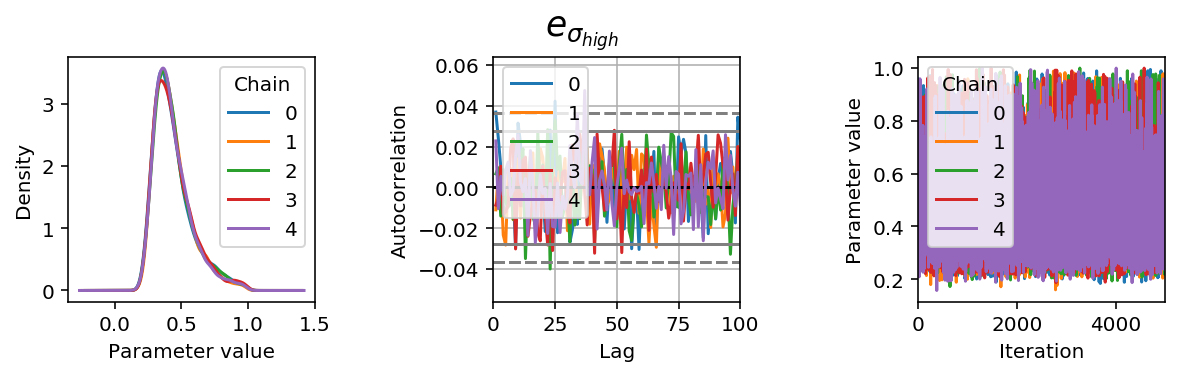

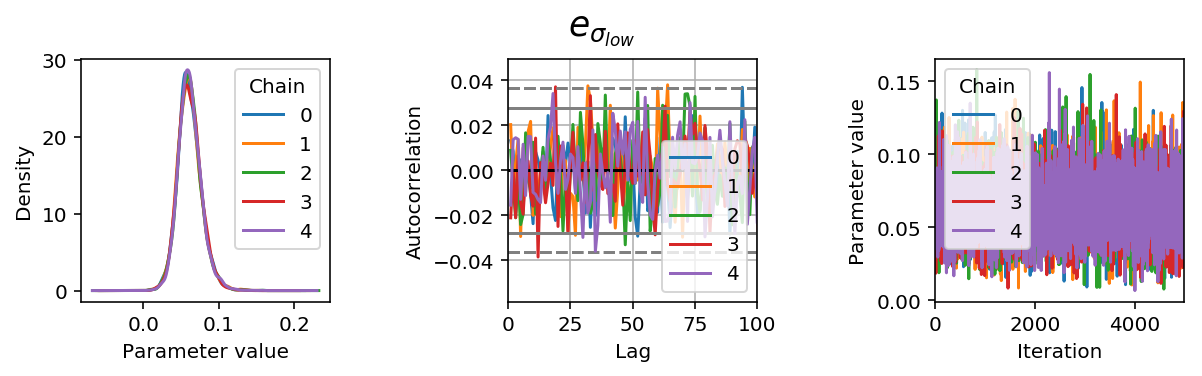

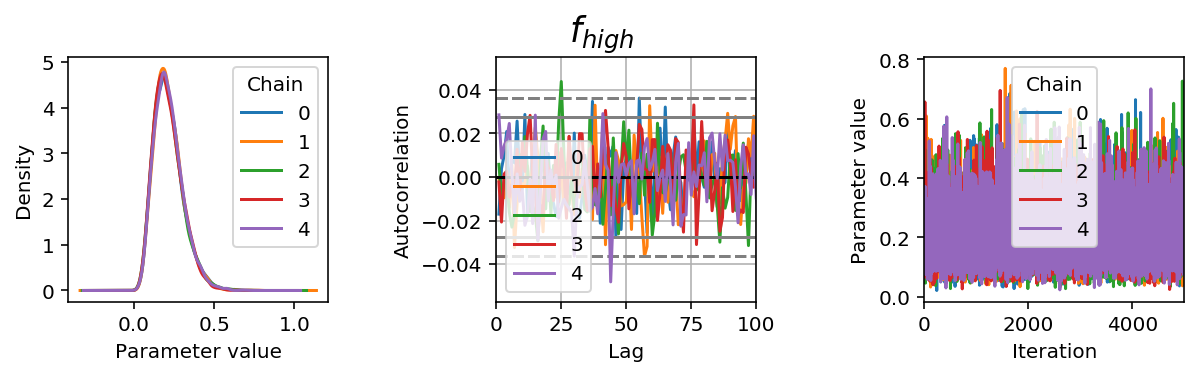

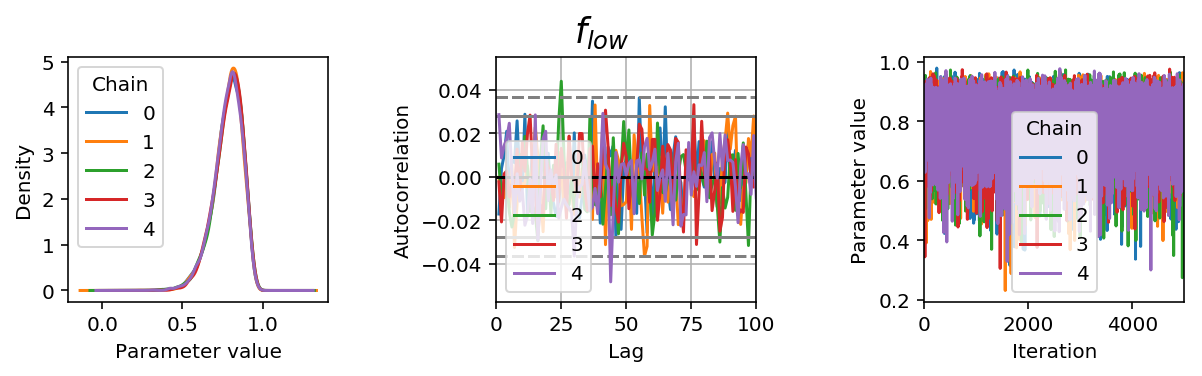

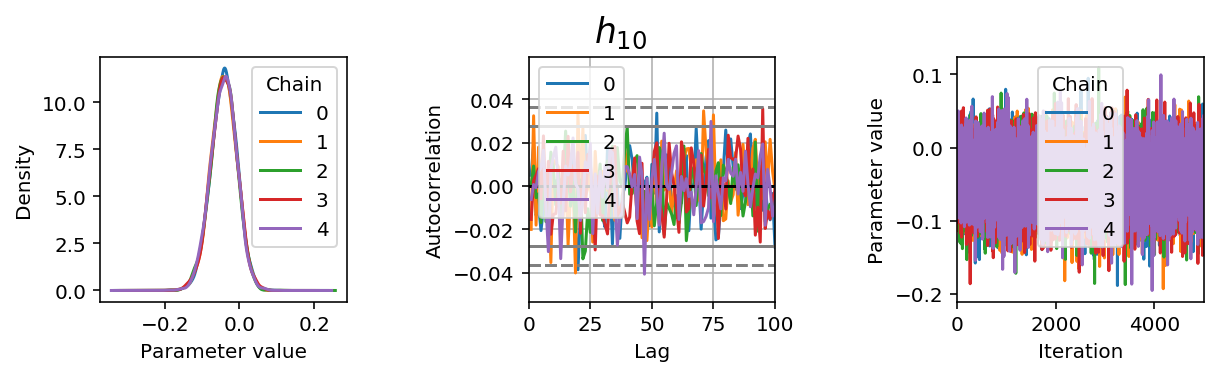

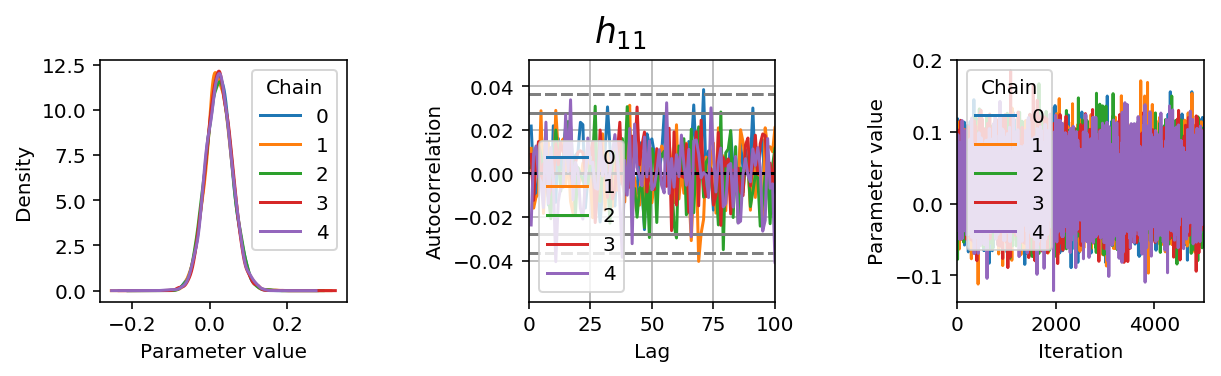

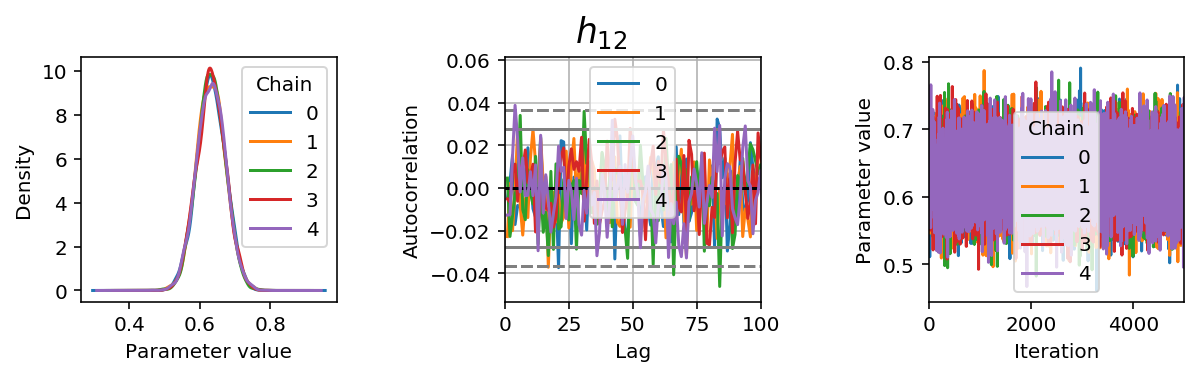

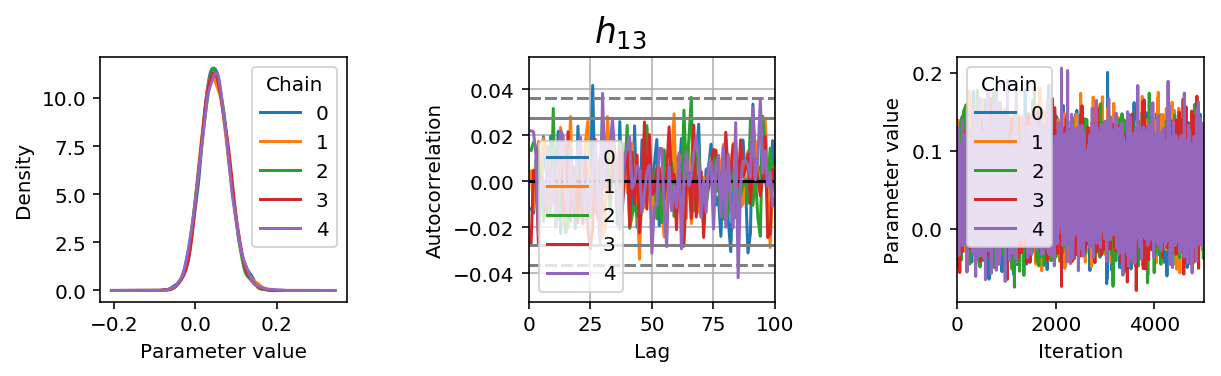

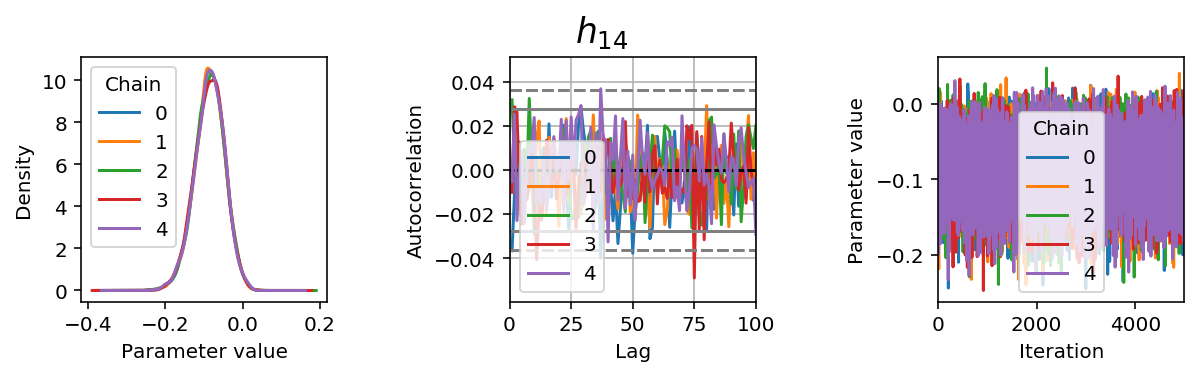

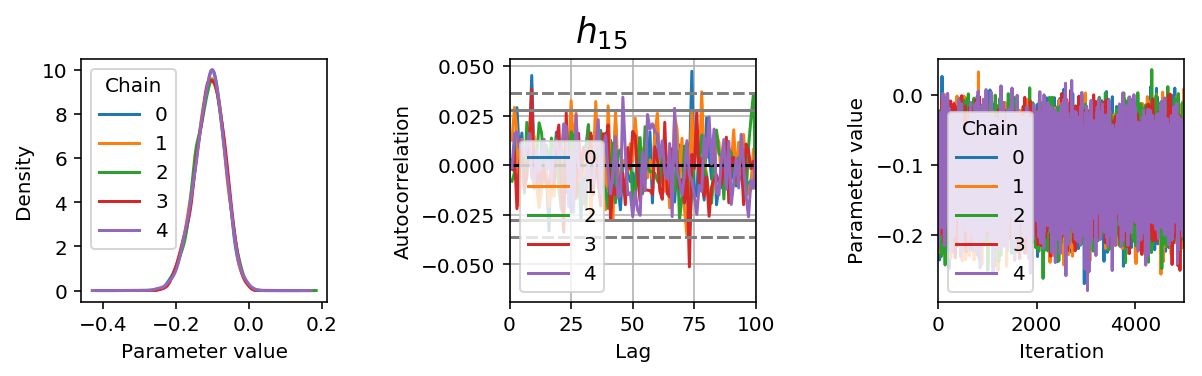

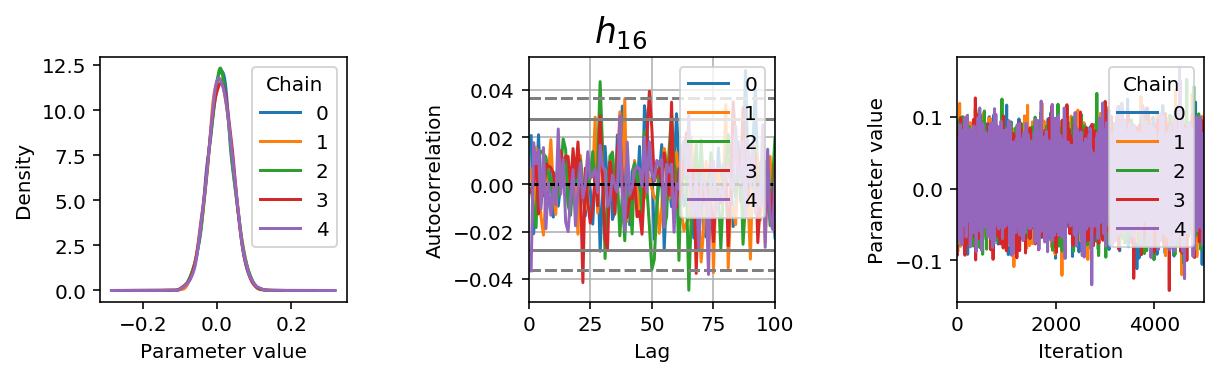

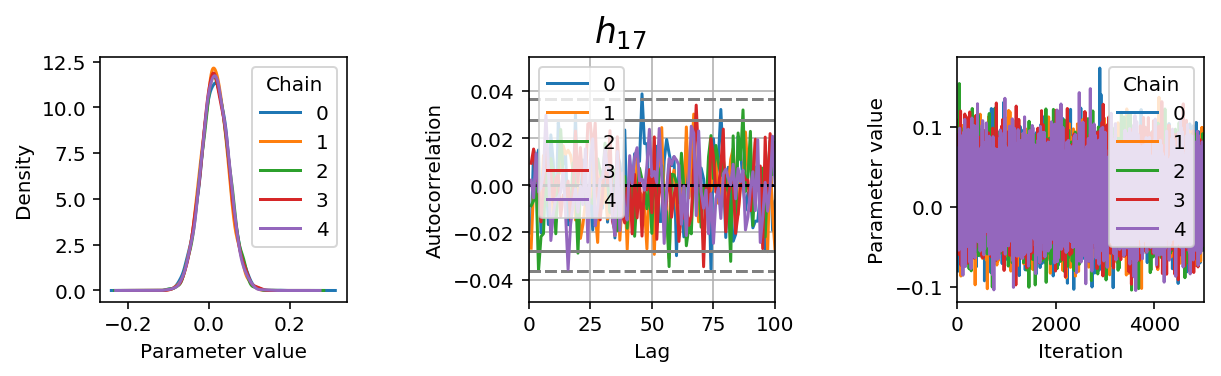

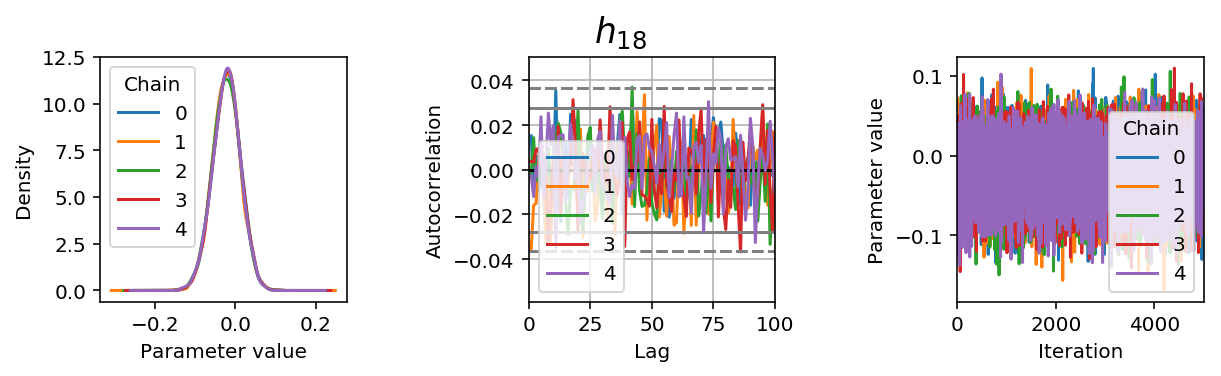

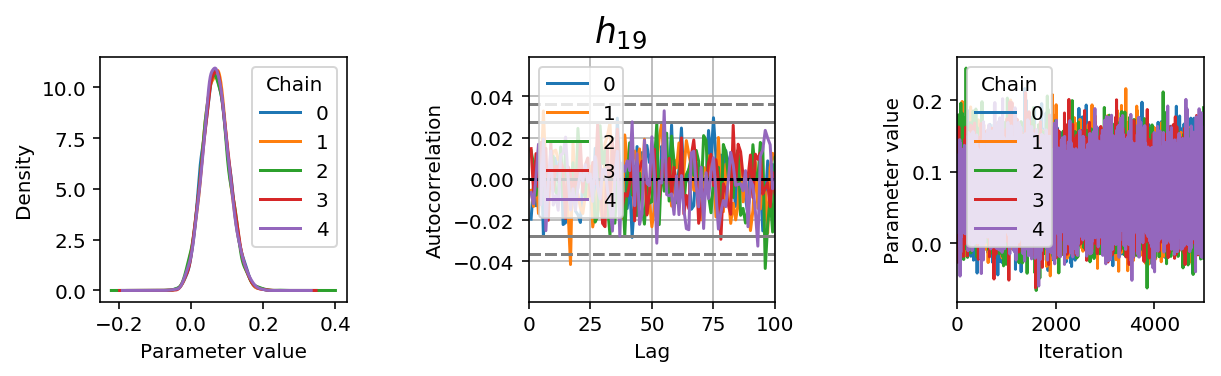

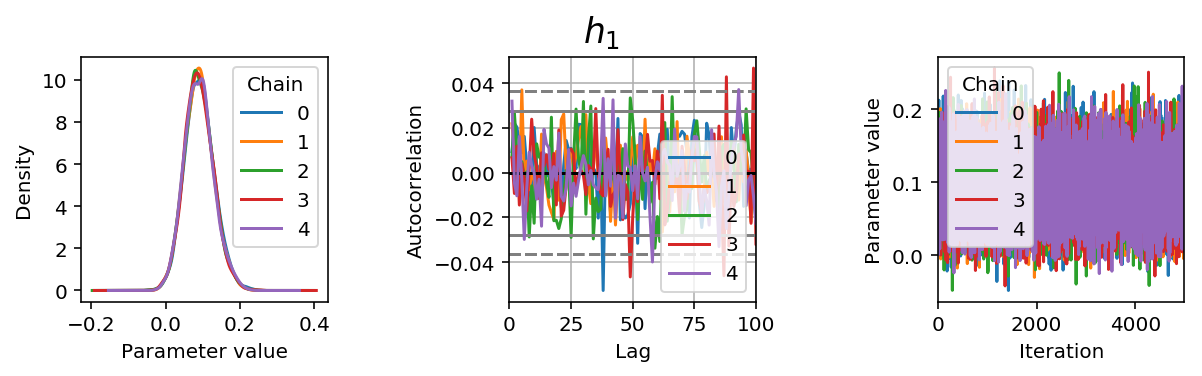

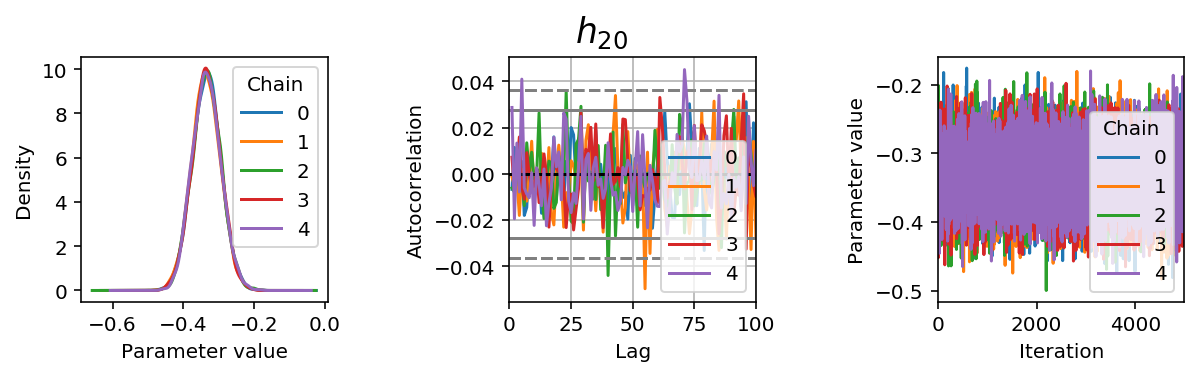

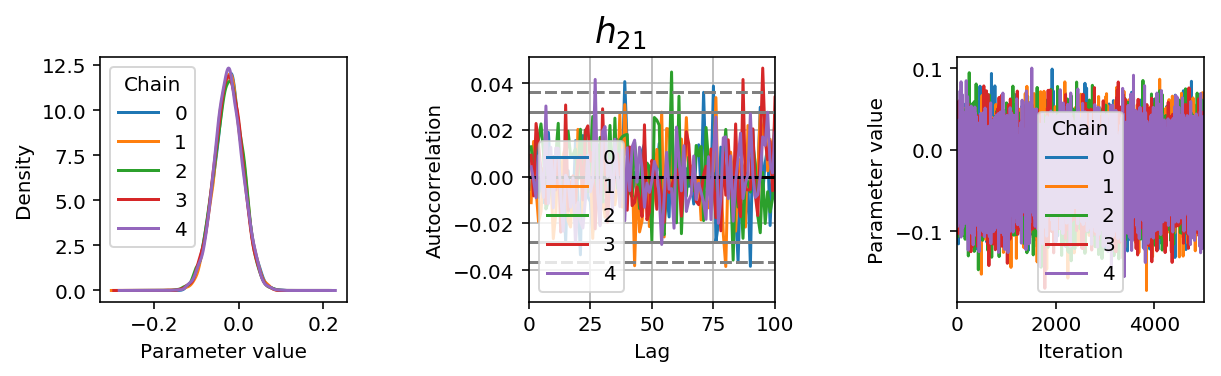

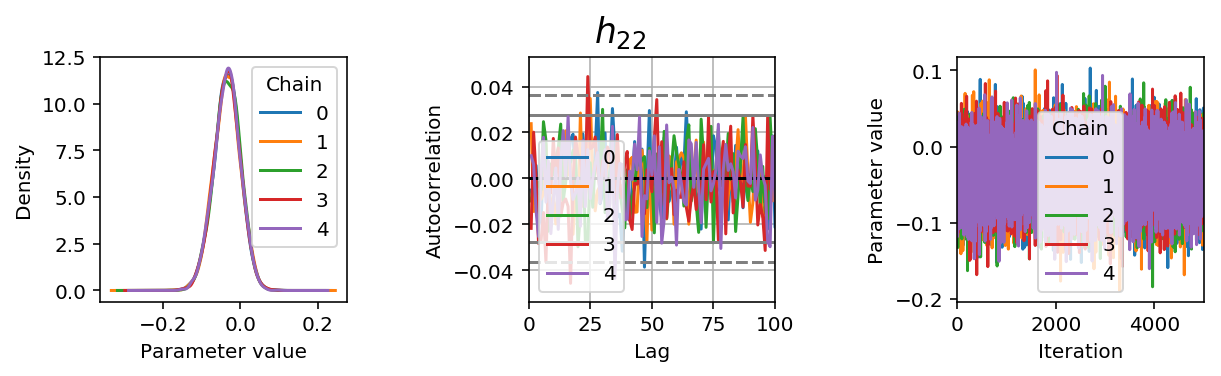

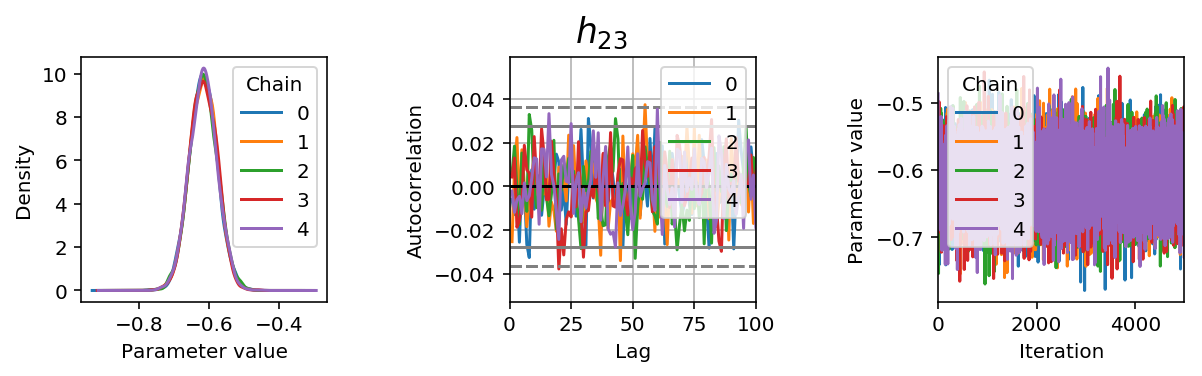

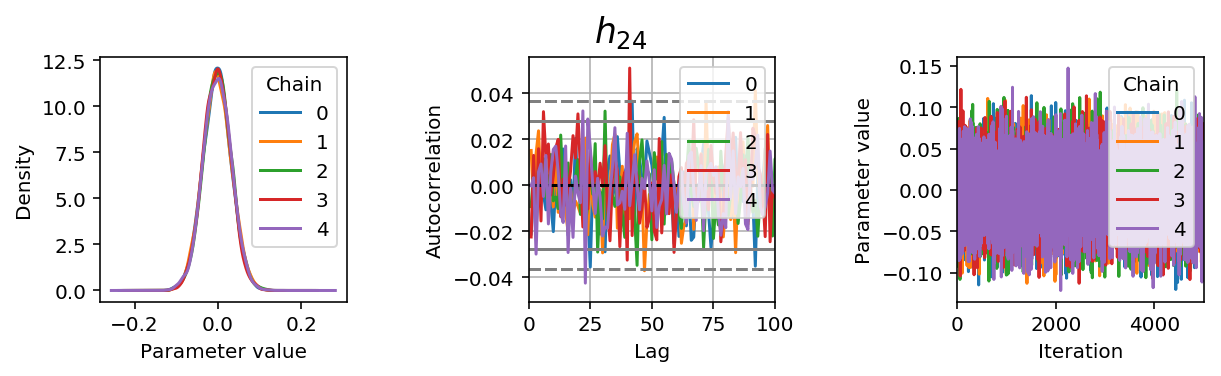

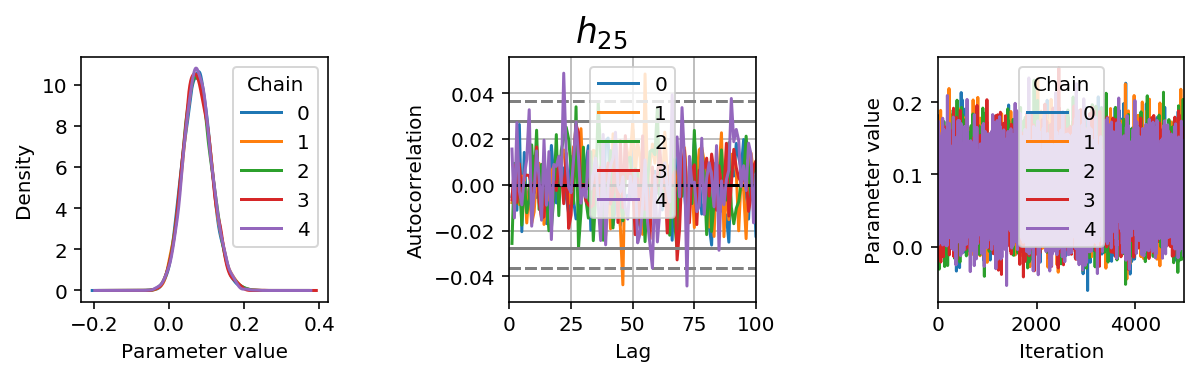

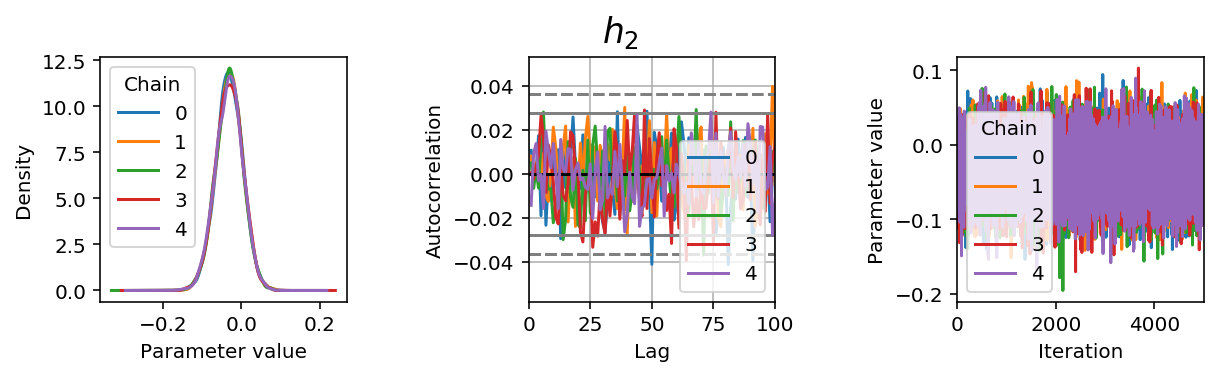

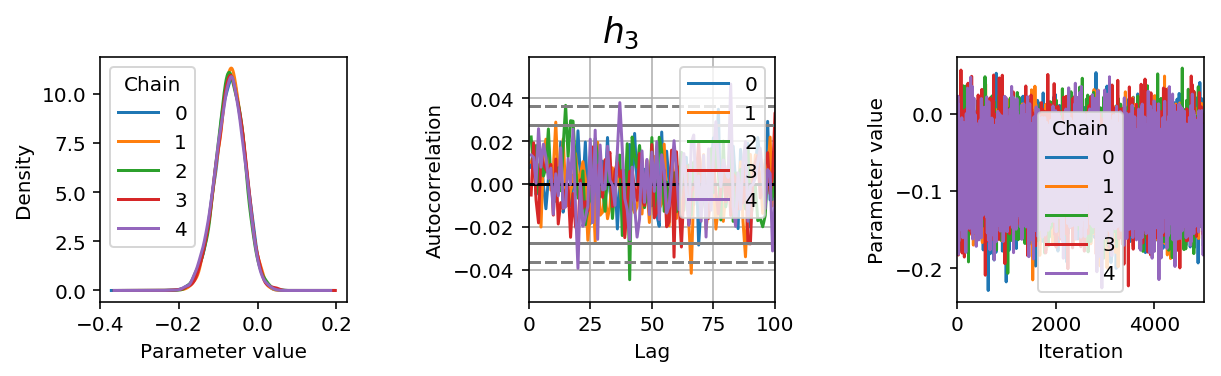

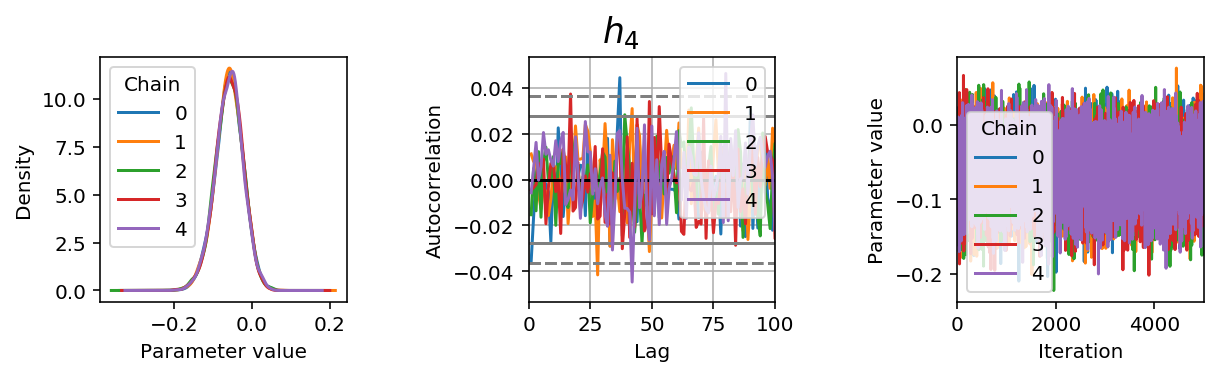

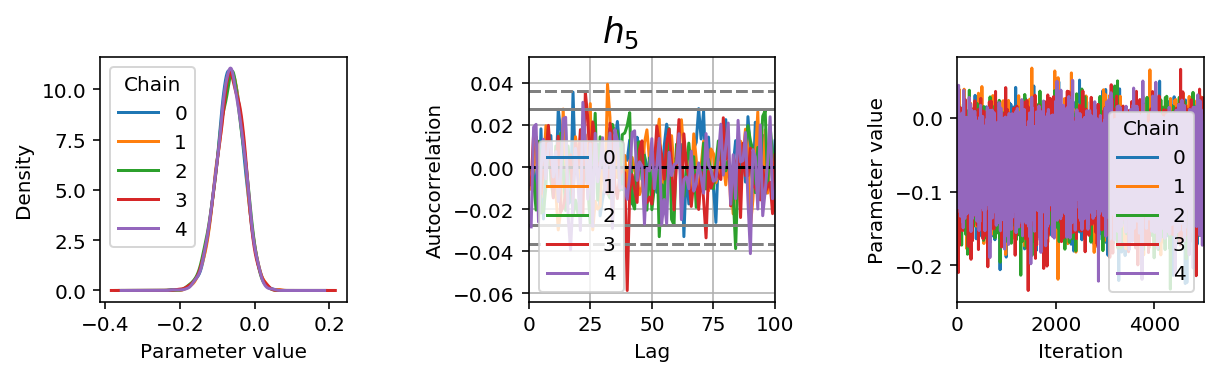

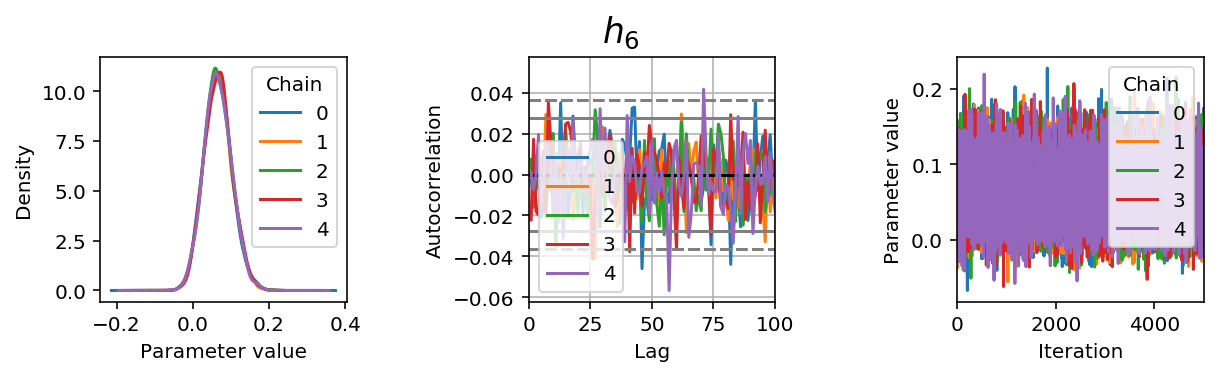

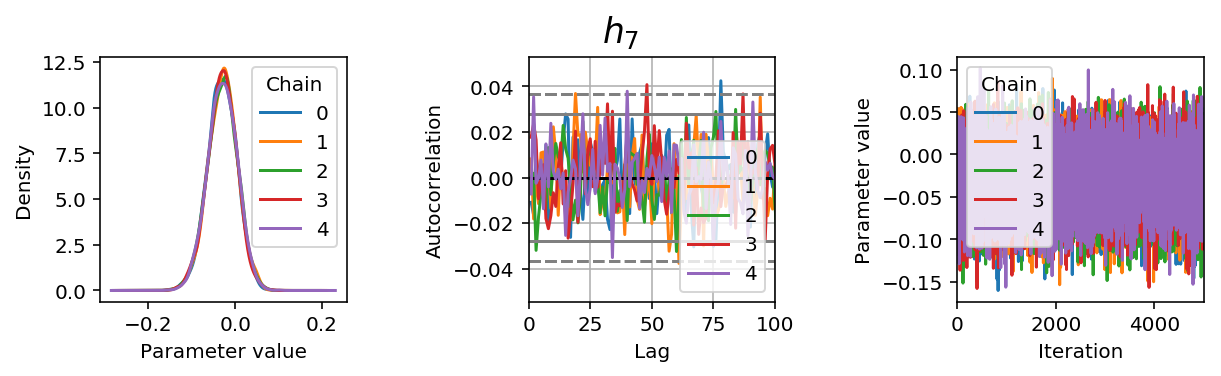

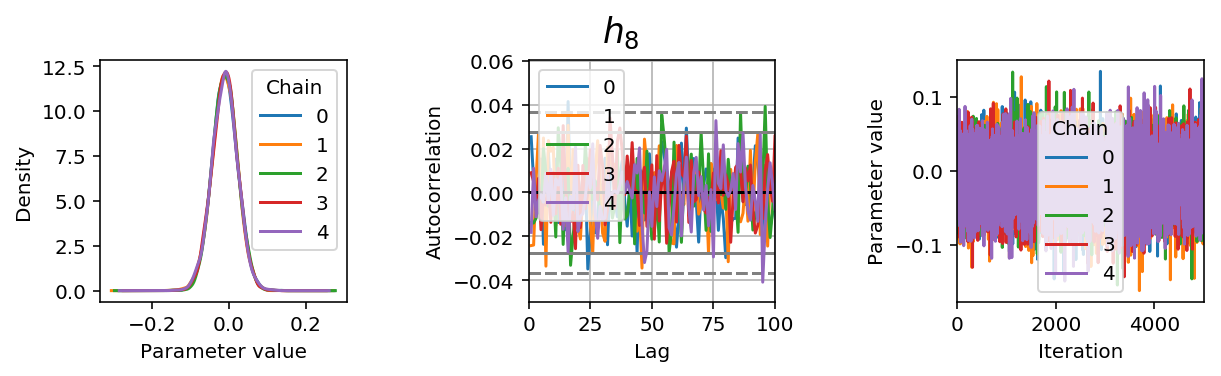

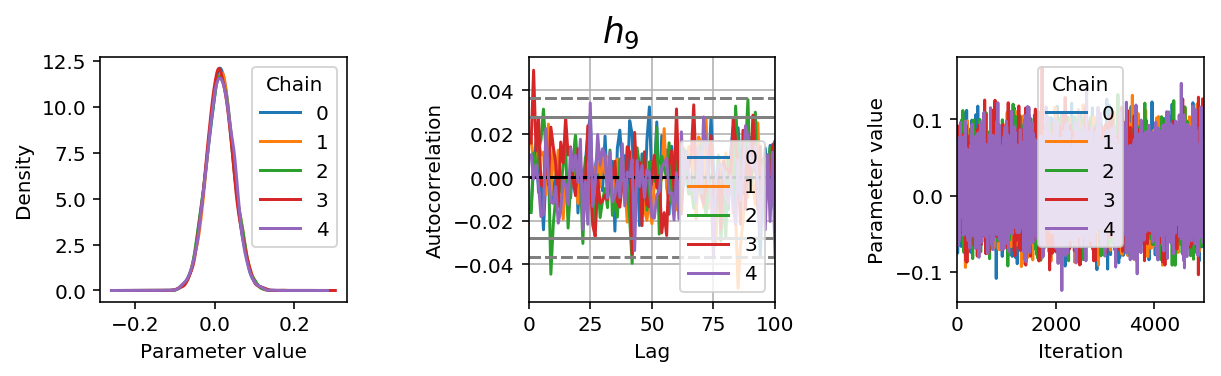

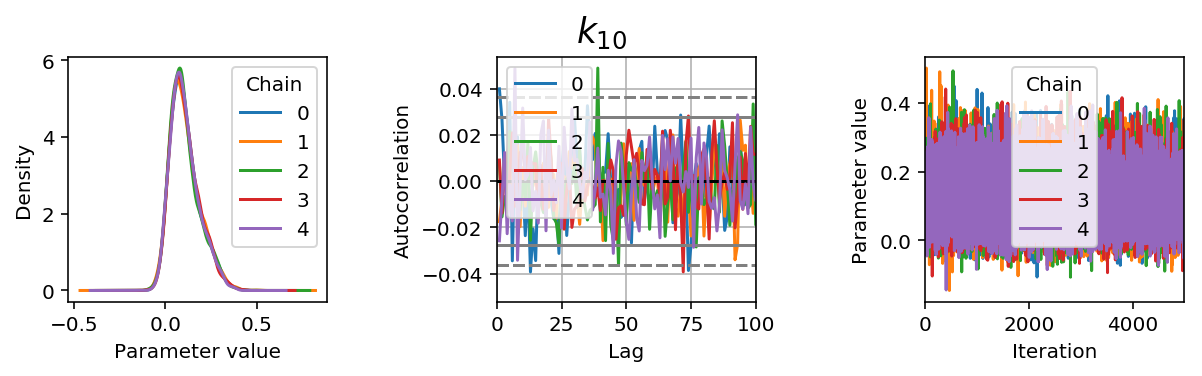

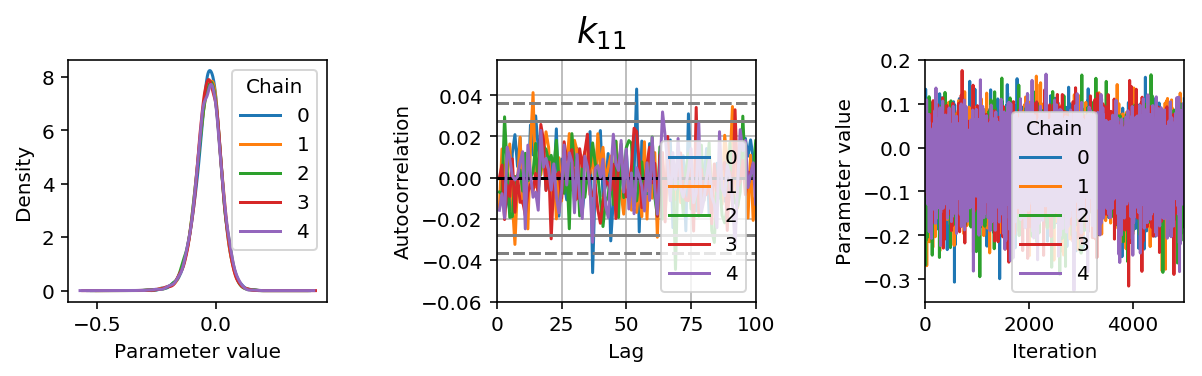

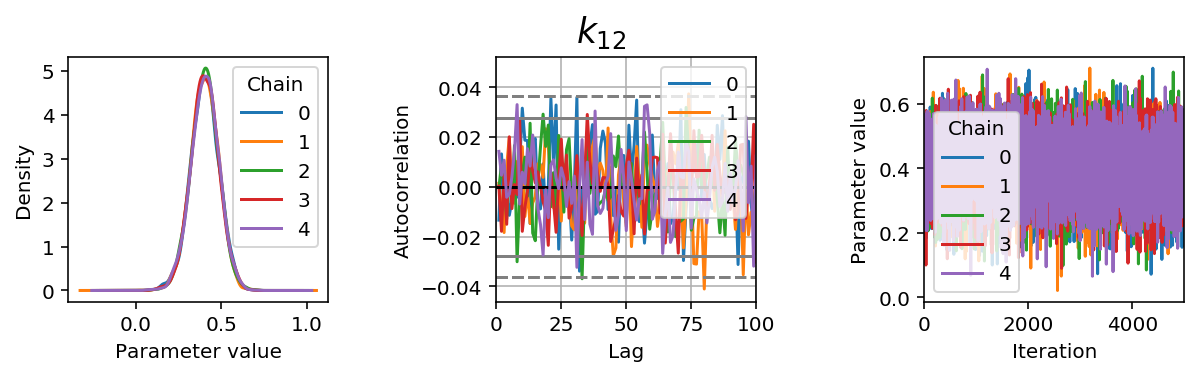

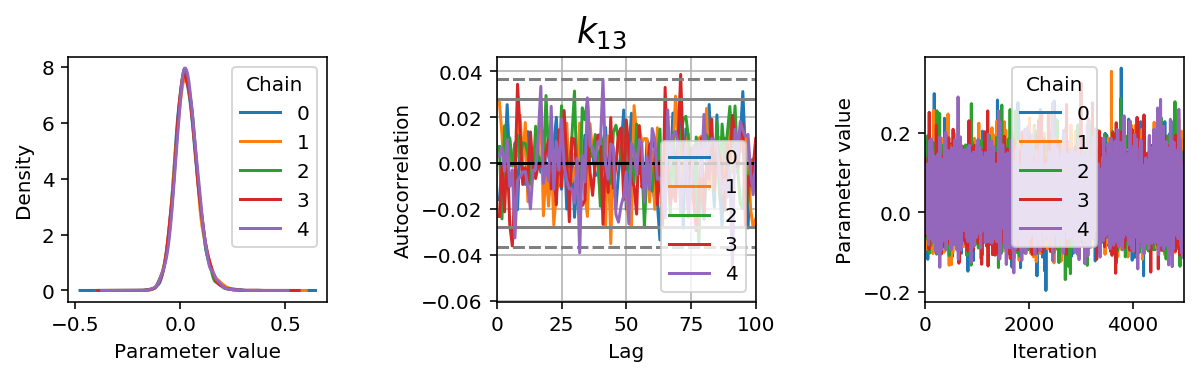

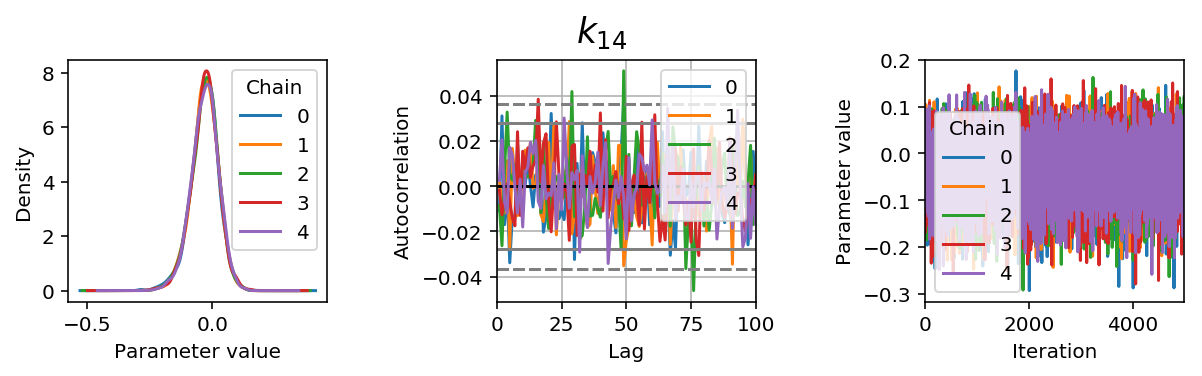

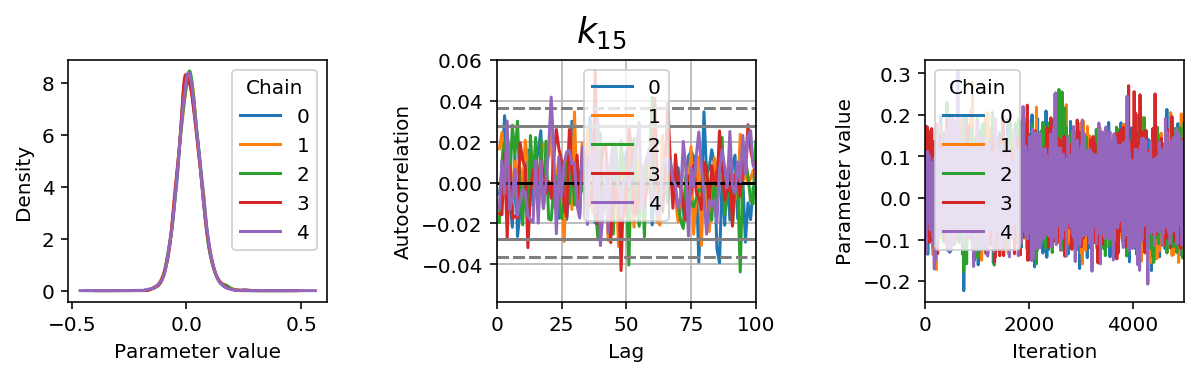

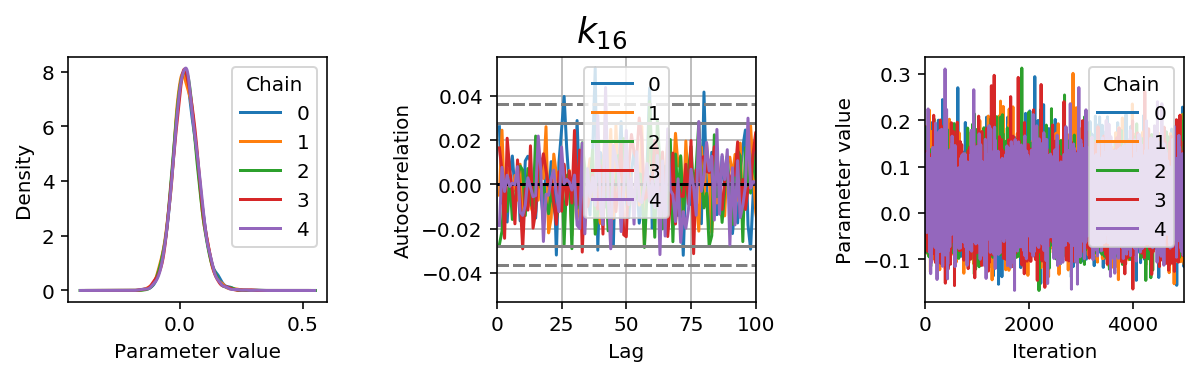

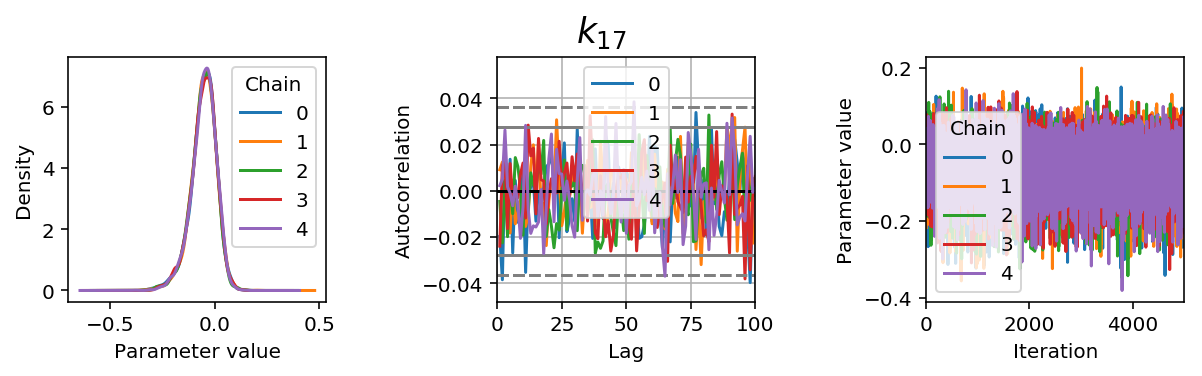

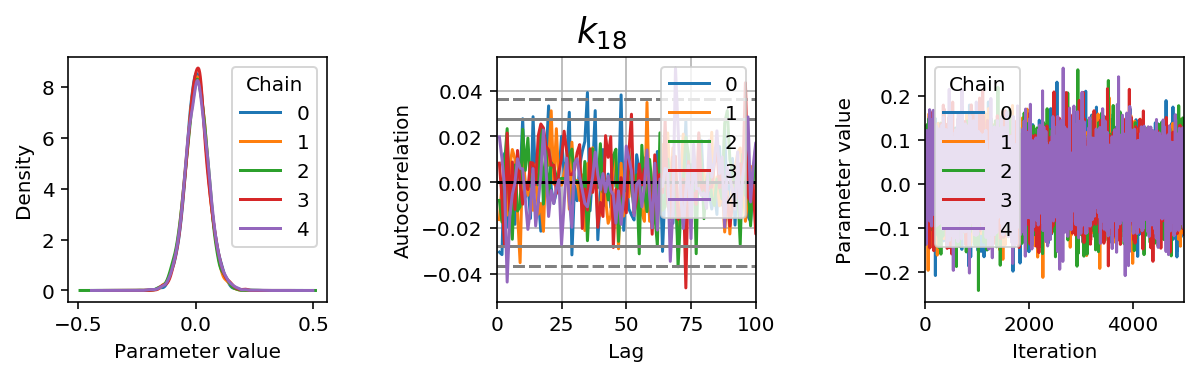

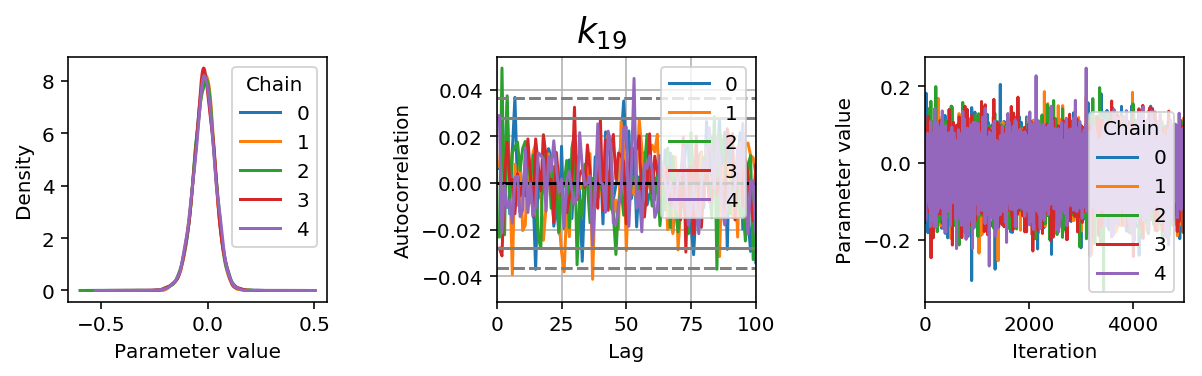

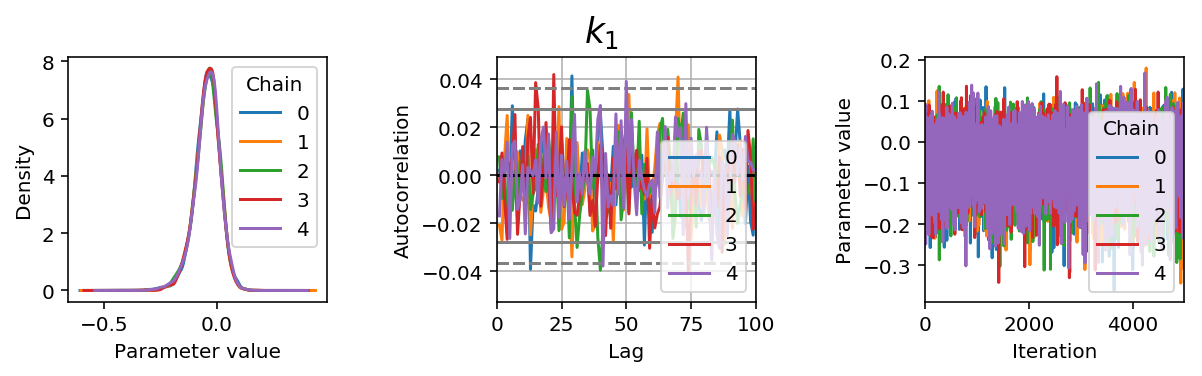

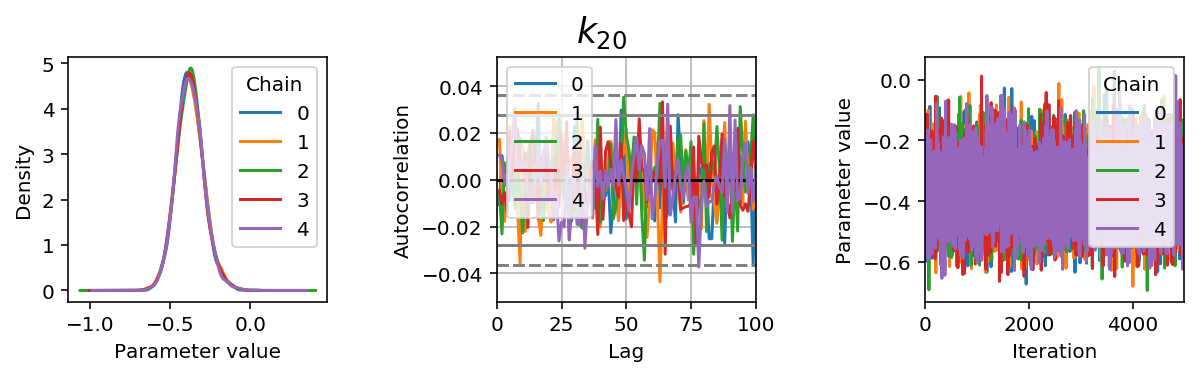

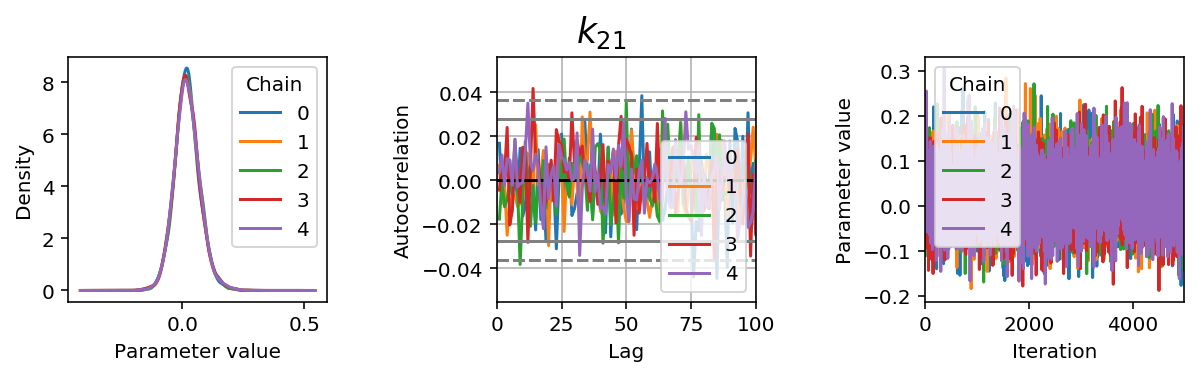

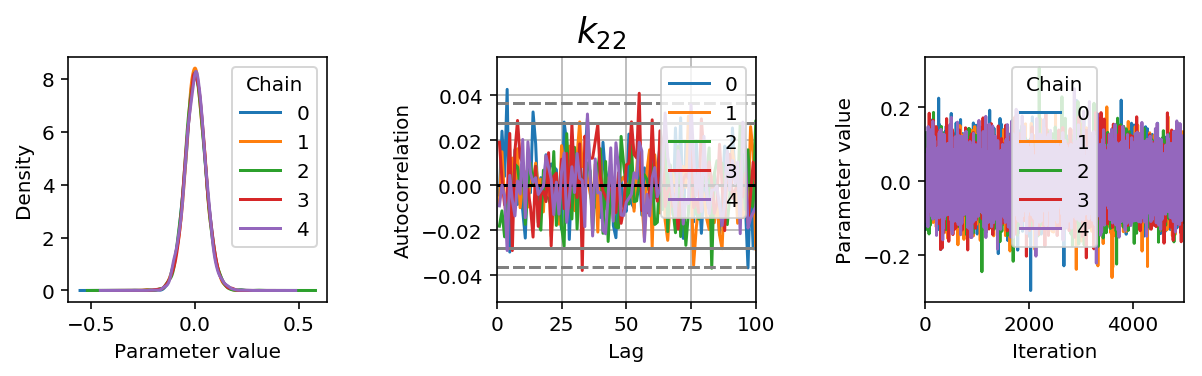

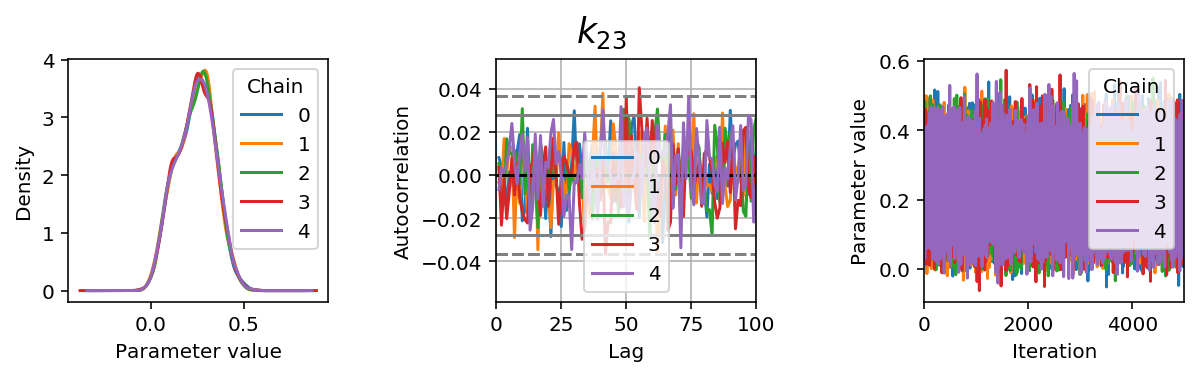

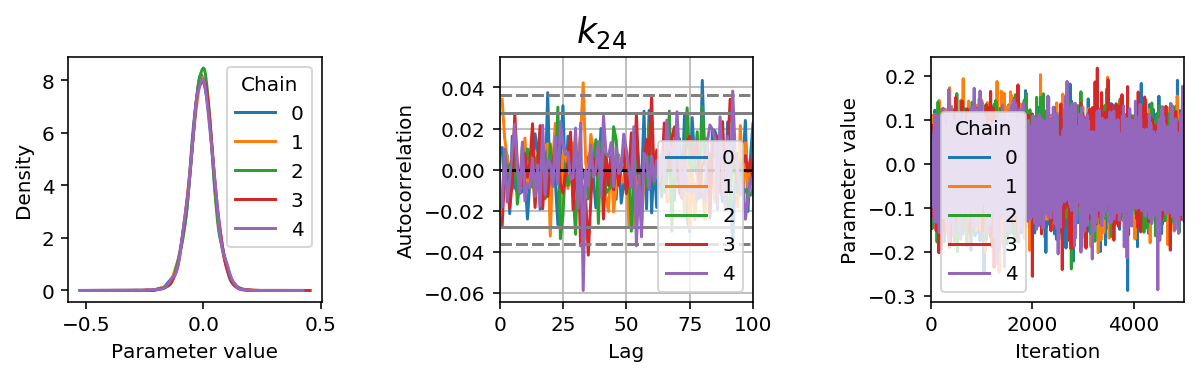

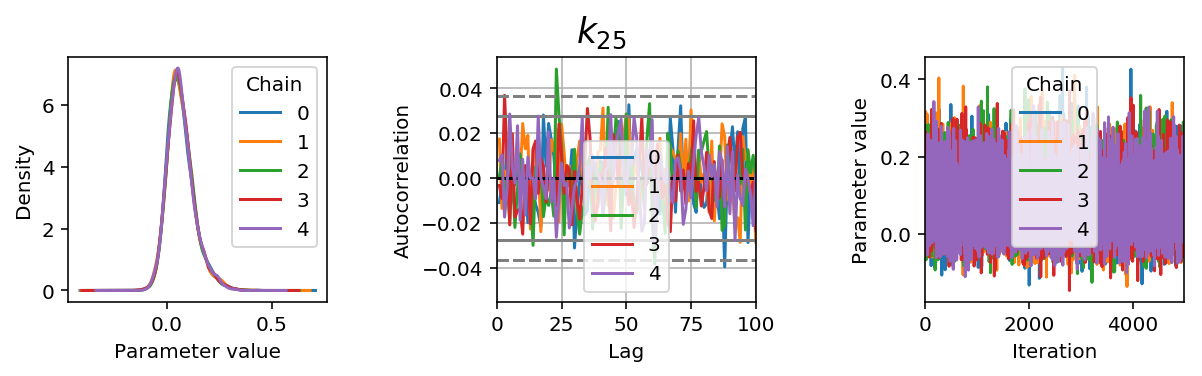

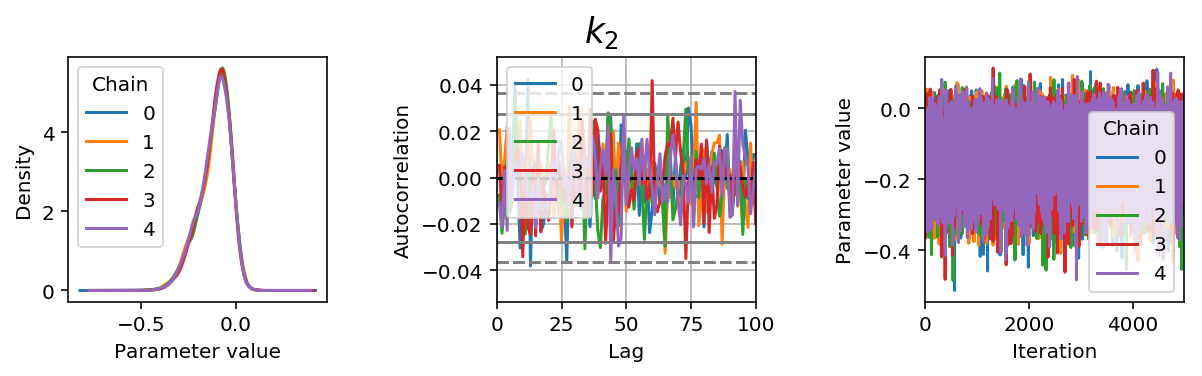

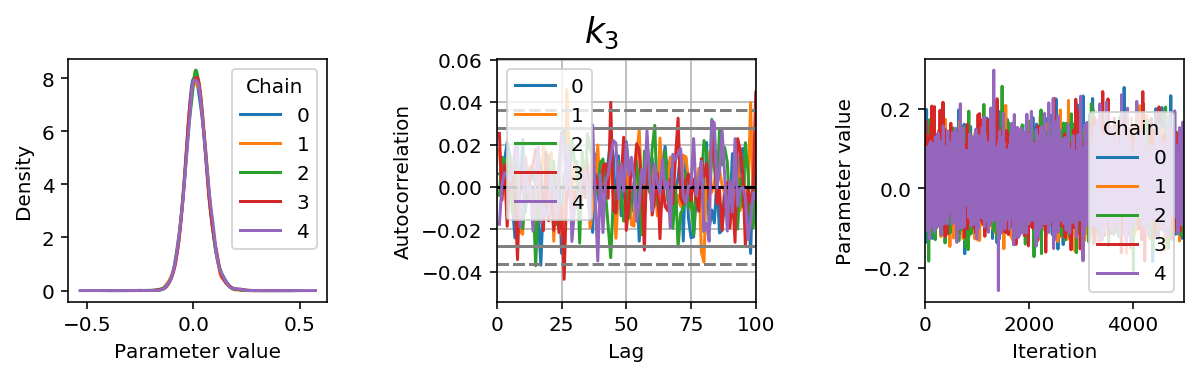

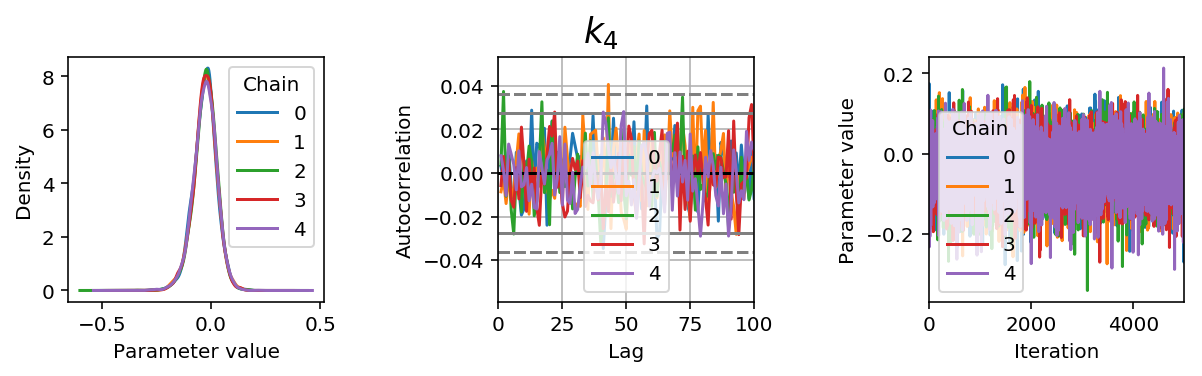

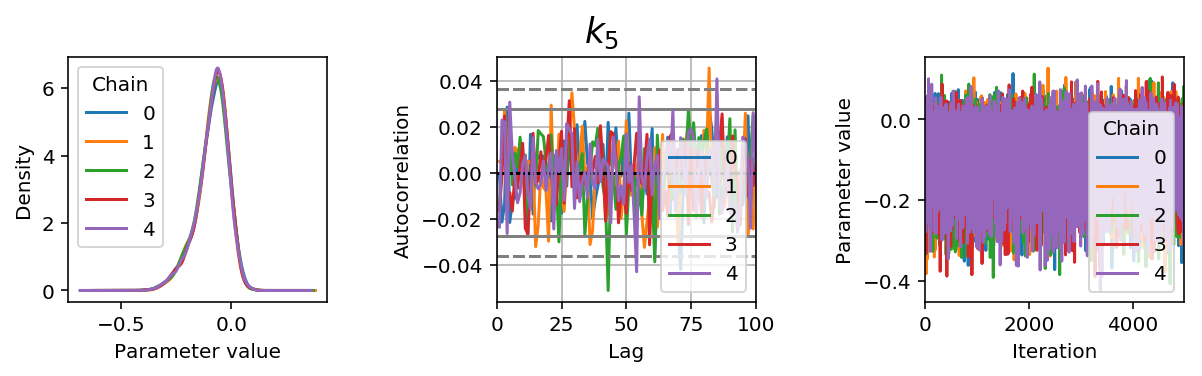

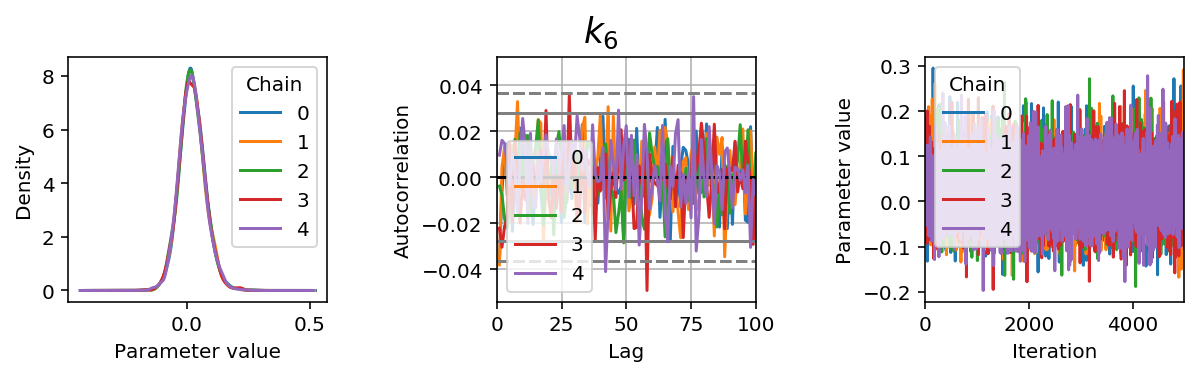

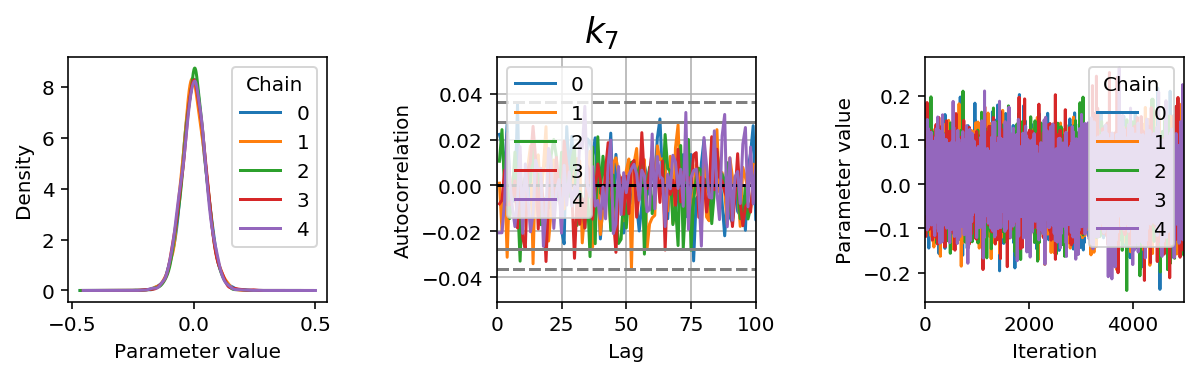

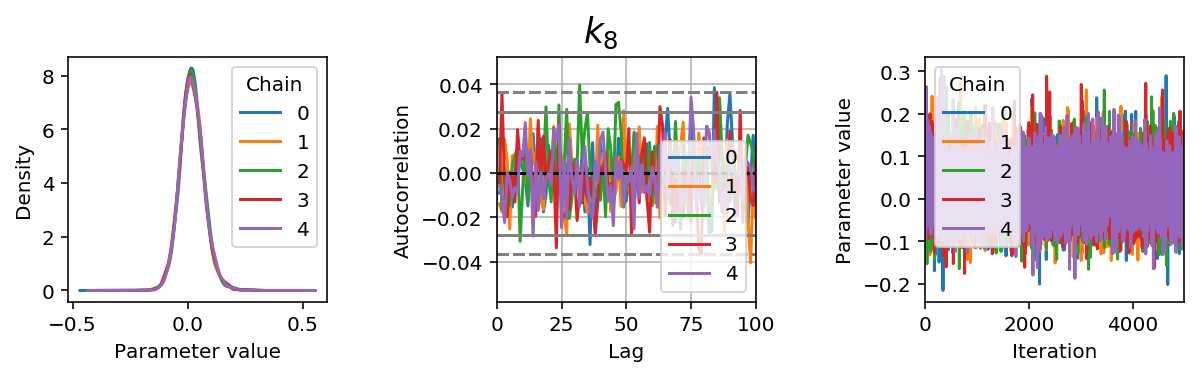

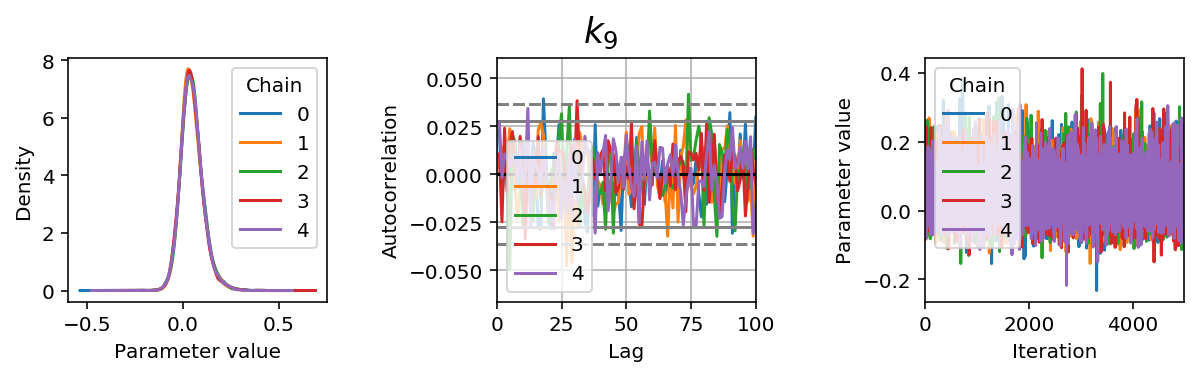

In [72]:
%%time
!date
## Use pandas three dimensional Panel to represent the trace:

trace_1_Stan = pd.Panel({k: v for k, v in samples_Nm2_trace_Stan.items()})
trace_1_Stan.axes[0].name = 'Variable'
trace_1_Stan.axes[1].name = 'Iteration'
trace_1_Stan.axes[2].name = 'Chain'
 
## Point estimates:
print(trace_1_Stan.to_frame().mean())
 
## Bayesian equal-tailed 95% credible intervals:
print(trace_1_Stan.to_frame().quantile([0.05, 0.95]))
  ## ^ entering the values here could be a good question part
    
def plot(trace, var):
    fig, axes = plt.subplots(1, 3, figsize=(9, 3))
    fig.suptitle(var, y=0.95, fontsize='xx-large')
 
    ## Marginal posterior density estimate:
    trace[var].plot.density(ax=axes[0])
    axes[0].set_xlabel('Parameter value')
    axes[0].locator_params(tight=True)
 
    ## Autocorrelation for each chain:
    axes[1].set_xlim(0, 100)
    for chain in trace[var].columns:
        autocorrelation_plot(trace[var,:,chain], axes[1], label=chain)
 
    ## Trace plot:
    axes[2].set_ylabel('Parameter value')
    trace[var].plot(ax=axes[2])
 
    ## Save figure
    filename = var.replace("\\", "") 
    filename = filename.replace("$", "") 
    filename = filename.replace("}", "") 
    filename = filename.replace("{", "") 
    plt.tight_layout(pad=3)
    fig.savefig('{}.png'.format(filename))
!date
# Display diagnostic plots
for var in trace_1_Stan:
    plot(trace_1_Stan, var);
 



In [73]:
## adjust the thin varible to only look at every #th population element 
##Ndata is 25 use 
thin = 5
##Ndata is 20 use
#thin = 4
numHyperParams = 4

## Re-specify the dimension we want for our plot below, with thinning, for legibility.  
dim2 = (Ndata/thin) + numHyperParams
print(dim2)
print(k.shape)
samples_Nm2_triangle_1_Stan = {}
truths_hhat = {}
truths_h = {}
for i in np.arange(0,Ndata,thin):
    print(i)
    print(samples_Stan['h'][:,i])
    print(samples_Stan['k'][:,i])
    print(h[i])
    print(k[i])
    print(hhat[i])
    print(khat[i])
    samples_Nm2_triangle_1_Stan.update({'$h_{'+str(i+1)+'}$': samples_Stan['h'][:,i],'$k_{'+str(i+1)+'}$': samples_Stan['k'][:,i]})
    truths_hhat.update({'$h_{'+str(i+1)+'}$': hhat[i],'$k_{'+str(i+1)+'}$': khat[i]})
    truths_h.update({'$h_{'+str(i+1)+'}$': h[i],'$k_{'+str(i+1)+'}$': k[i]})
samples_Nm2_triangle_1_Stan.update({'$e_{\sigma_{low}}$': e_sigma_low,'$e_{\sigma_{high}}$': e_sigma_hi,'$f_{low}$': f_low,'$f_{high}$': f_high})
truths_hhat.update({'$e_{\sigma_{low}}$': e_sigma_low,'$e_{\sigma_{high}}$': e_sigma_hi,'$f_{low}$': f_low,'$f_{high}$': f_high})
truths_h.update({'$e_{\sigma_{low}}$': e_sigma_low,'$e_{\sigma_{high}}$': e_sigma_hi,'$f_{low}$': f_low,'$f_{high}$': f_high})



9.0
(25,)
0
[ 0.05373502  0.15097105  0.09843625 ...,  0.14344713  0.11583189
  0.12358905]
[-0.01819928  0.0220263  -0.18225842 ..., -0.05127983 -0.01849644
 -0.1383102 ]
-0.1513747893
0.156374353409
-0.150326123742
0.192718989214
5
[ 0.08667085  0.03088594  0.06424168 ...,  0.04943662  0.11958057
  0.05725992]
[ 0.00131643  0.01463321  0.01115562 ..., -0.00759236  0.03963672
 -0.01426332]
-0.00346412284263
0.00366181077158
0.0722686105641
-0.0657144370777
10
[ 0.02999202  0.04422179  0.08773901 ...,  0.05064671  0.01149459
  0.01658866]
[-0.04657135 -0.0414787   0.00014065 ..., -0.12709354 -0.00998583
 -0.11504946]
0.00543866120826
-0.00206863909727
-0.0237298243217
0.033321650102
15
[ 0.02294238  0.0274011   0.04539293 ..., -0.03837752 -0.0056582
 -0.04325633]
[ 0.07026289 -0.03043622  0.01206642 ...,  0.01755496  0.1476869
 -0.02455684]
0.0902062262402
0.0494782083068
0.0967159736838
0.0235471656694
20
[ 0.00319767  0.00460741  0.0002455  ..., -0.01861399 -0.03551001
 -0.01864312]


In [74]:
print(samples_Nm2_triangle_1_Stan.keys())
print(int(dim2))
print(truths_hhat.values())

['$h_{16}$', '$k_{6}$', '$h_{21}$', '$h_{6}$', '$e_{\\sigma_{low}}$', '$k_{16}$', '$h_{1}$', '$h_{11}$', '$f_{low}$', '$f_{high}$', '$k_{1}$', '$k_{11}$', '$e_{\\sigma_{high}}$', '$k_{21}$']
9
[0.09671597368377674, -0.065714437077664792, 0.031750287624040405, 0.072268610564149738, array([ 0.05060286,  0.0771424 ,  0.07119436, ...,  0.06446178,
        0.05191015,  0.0762385 ]), 0.023547165669406078, -0.15032612374231302, -0.023729824321730611, array([ 0.87853327,  0.79134321,  0.90513068, ...,  0.77583082,
        0.7033808 ,  0.83945185]), array([ 0.12146673,  0.20865679,  0.09486932, ...,  0.22416918,
        0.2966192 ,  0.16054815]), 0.19271898921393335, 0.033321650101986462, array([ 0.74246119,  0.51616174,  0.34046479, ...,  0.41658485,
        0.38053465,  0.39028953]), 0.012759839405289301]


Tue Dec 19 18:09:55 PST 2017
(25000, 14)


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

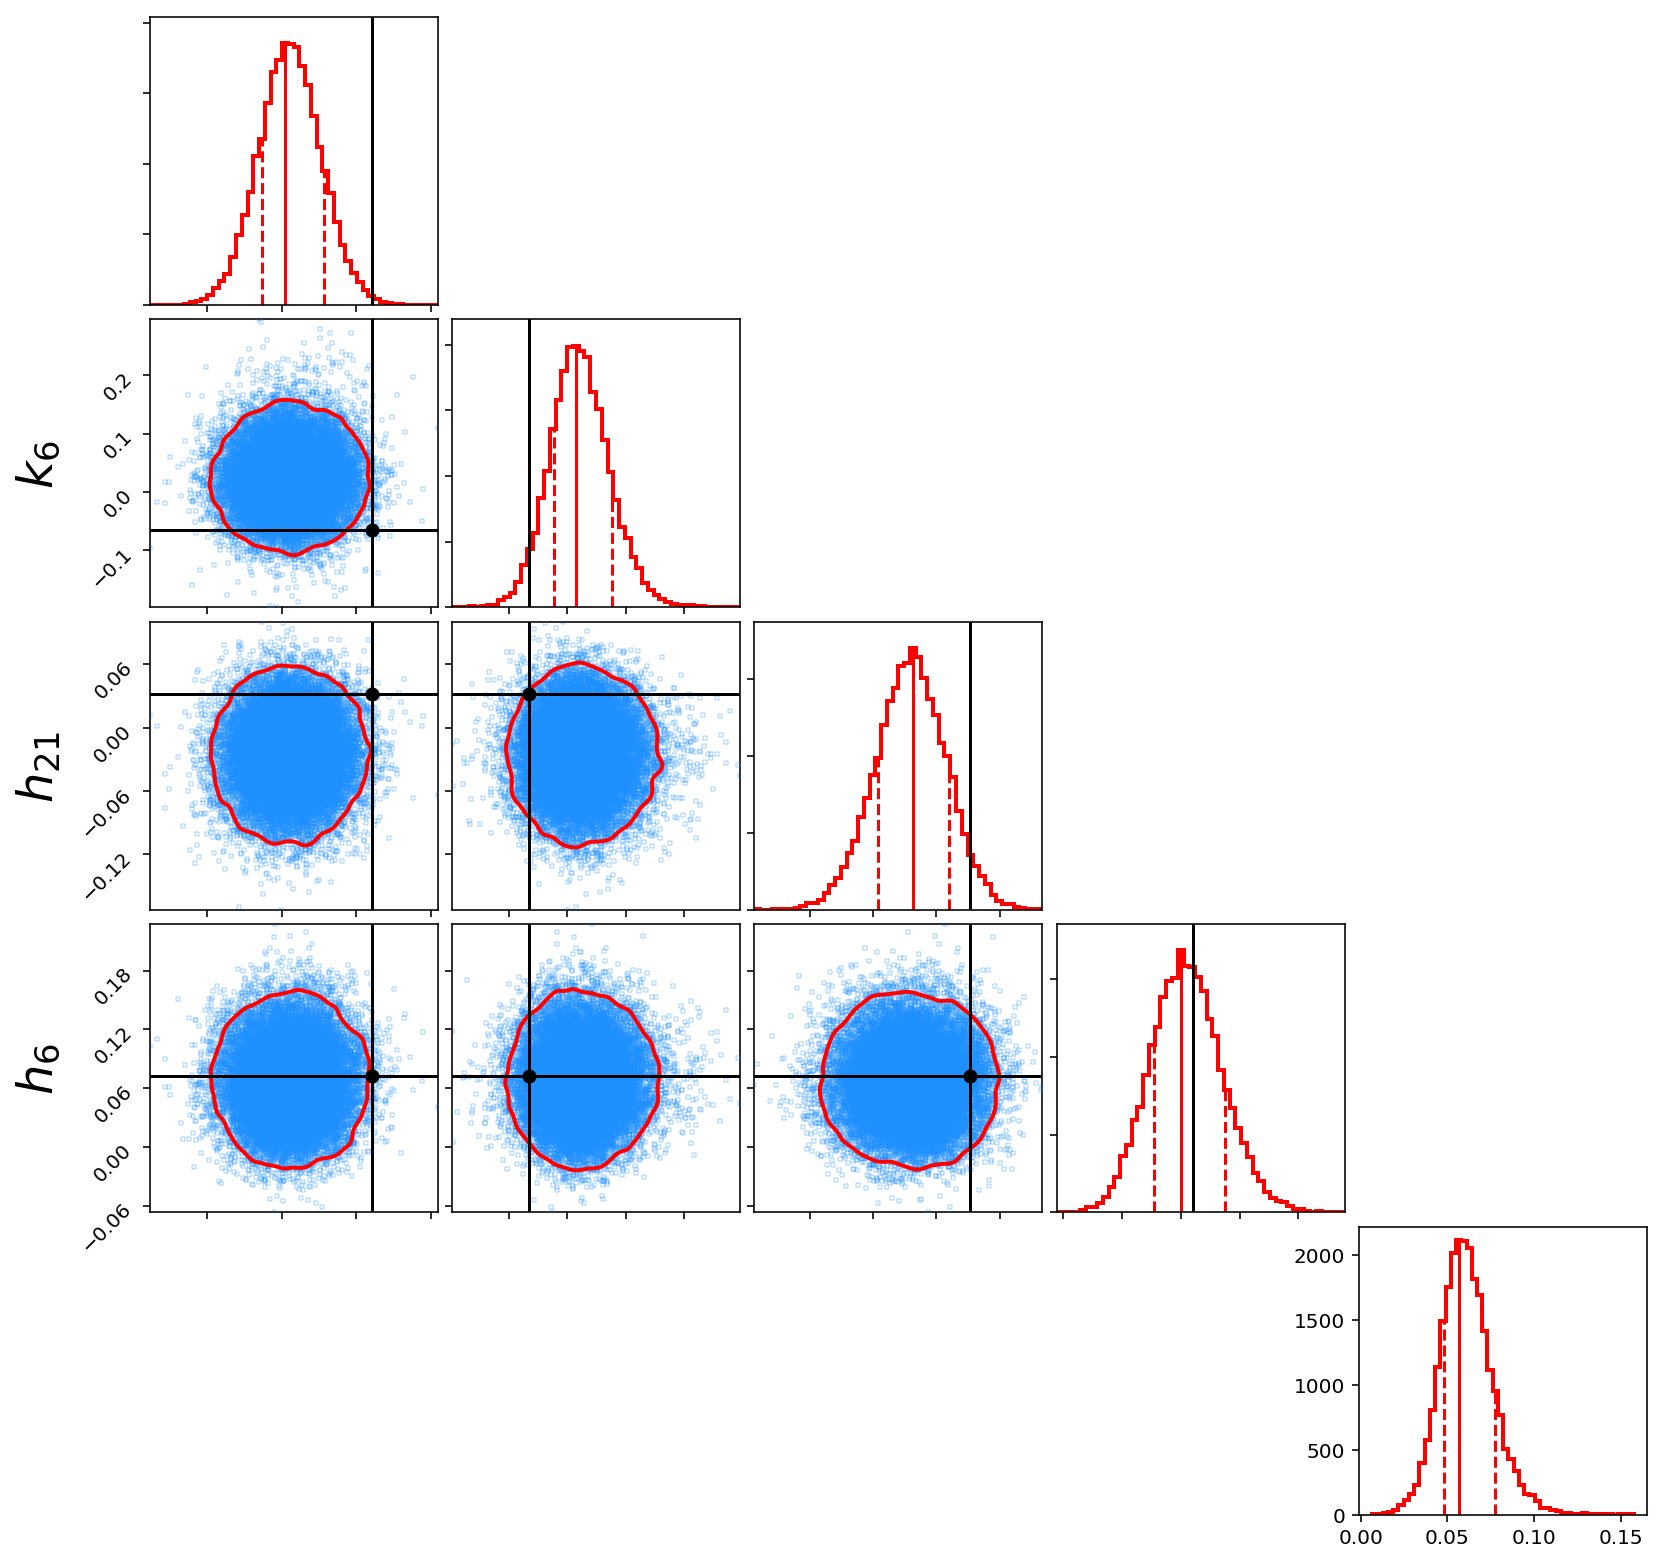

In [79]:
%%time
!date

import triangle_linear
#data = np.asarray(samples_Nm1_scatter_matrix_triangle.values()).reshape((5000*num_chains),int(dim2))
#print(np.asarray(samples_Nm1_scatter_matrix_triangle.values()).reshape((5000*num_chains),int(dim2)).shape)

samples_Nm2_triangle_2_Stan = {}    
for j, i in samples_Nm2_triangle_1_Stan.items():
    samples_Nm2_triangle_2_Stan.update({str(j): i.reshape(-1,1)})
    
data = None
for k, v in samples_Nm2_triangle_2_Stan.items():
    column = v.reshape(-1,1)
    if data is None:
        data = column
    else:
        data = np.hstack((data, column))

print(data.shape)

figure = triangle_linear.corner(data,labels=samples_Nm2_triangle_2_Stan.keys(),labelsy=samples_Nm2_triangle_2_Stan.keys(), truths=truths_hhat.values(), truths_color = 'black')

plt.savefig('triangle_linear_Nm2_Stan.png')
!date

<h2 align="center">Part 2: Explore Matt Trick or non-centered parameterization somehow</h2>

In [45]:
eccmodel = """
data {
    int<lower=1> Nm;
    int<lower=1> Ndata;
    real<lower=-1,upper=1> hhat[Ndata];
    real<lower=0,upper=1> hhat_sigma[Ndata];
}

parameters {
    simplex[2] f;
    real<lower=0> e_sigma[2];
    real<lower=-1,upper=1> h[Ndata];
    real h_tilde[Ndata];

}


model {
    e_sigma ~ uniform(0, 1.0);
    h_tilde ~ normal(0, 1);

    for (n in 1:Ndata)
      hhat[n] ~ normal(h[n], hhat_sigma[n]);

    for (n in 1:Ndata)
      increment_log_prob(log_mix(f[1], normal_log(h[n], 0.0, e_sigma[1] * h_tilde[n]), normal_log(h[n], 0.0, e_sigma[2] * h_tilde[n])));
}
"""
# Compiled Stan Model
sm = StanModel(model_code=eccmodel)